In [1]:
# importing libraries; we will need additional machine learning libraries here.
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
np.set_printoptions(legacy='1.25')

In [2]:
full_dataframe = pd.read_csv('../data/processed/transformed_data.csv')


Recall that our dataframe currently has data from four separate years. We want to build models where we predict what will happen in a given year, so we need to split the data out by year. To do this, and to get exactly the data we eed for each model type in its respective dataframe, we will build dataframes to use for model building as follows:
One set of dataframes will be used for predicting policies based only on basic data about a country. For these models, we will need dataframes containing only net trade status and basic data from the previous year as inputs, and subsidy data from the year being predicted as outputs. Another set of dataframes will have all this data in addition to the subsidy data from the previous year as an additional set of inputs.


In [3]:
basic_prediction_dataframes = {}
full_prediction_dataframes = {}

for year in range(2021,2025):
    columns = ['Country Code', 'Net Trade Status', 'Price Control in ' + str(year), 'Tax Reduction in ' + str(year), 'No subsidy in ' + str(year), 'Some subsidy in ' + str(year), 'Price freezes in ' + str(year), 'log_gdp data in ' + str(year - 1), 'log_population data in ' + str(year - 1), 'democracy index data in ' + str(year - 1), 'log_population density in ' + str(year - 1)]
    df = full_dataframe[columns].copy()
    # Removing 'in year' from column names so they combine nicely
    df.rename(columns = lambda x: x[:-8] if x[-4:-1] == '202' else x, inplace = True)
    # full_prediction_dataframes[year] = df.copy()
    basic_prediction_dataframes[year] = df.copy()

for year in range(2022,2025):
    columns = ['Country Code', 'Price Control in ' + str(year - 1), 'Tax Reduction in ' + str(year - 1), 'No subsidy in ' + str(year - 1), 'Some subsidy in ' + str(year - 1), 'Price freezes in ' + str(year - 1)]
    df = pd.merge(full_dataframe[columns], basic_prediction_dataframes[year])
    # Removing 'in year 202x' from column names so they combine nicely
    df.rename(columns = lambda x: (x[:-7] + "in previous year") if x[-4:-1] == '202' else x, inplace=True)
    full_prediction_dataframes[year] = df

With some dataframes created, let's look at the first round of models we will be building. These models will be logistic regression models and random forests, which we will be using scikit-learn's LogisticRegression and RandomForestClassifier for. We will be building separate models for each y variable, since logistic regression only works with one target variable.

In addition, we will try training and testing the models in a couple different ways. In one method, we will train the models on data from 2021 through 2023, and then test them on the 2024 data. This has the advantage of accurately simulating how the model will perform in a real world scenario, where it is using the past to predict the future. In another method, we will put data from all years together into one large dataframe, and then train the model on that using 5-fold cross validation. This has the advantage of including all the data in both the training and testing sets, which reduces the likelihood of any patterns in the data being missed.

Let's first define a function we will be using to train and test all of our models, and then start with the Linear regression models using data from all years in the same dataset.

As for technical details, we will be using 5-fold cross validation, and we will look at the confusion matrices and log losses. We will also use class_weight = balanced, to ensure the model isn't biased towards the more common policies.


In [4]:
def score_results(actual, predicted, probs, title):
    cm = confusion_matrix(actual, predicted)

    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Did not implement', 'Implemented'], yticklabels=['Did not implement', 'Implemented'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    precision = cm[1][1] / (cm[1][1] + cm[0][1])
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    f1_score = 2 * (precision * recall) / (precision + recall)
    logloss = log_loss(actual, probs)
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("f1 score: " + str(f1_score))
    print("Log loss: " + str(logloss))
    return (precision, recall, f1_score, logloss)

def train_and_test_model(model, dataset, x_columns, y_columns):
    scores = {}
    models = {}
    for col in y_columns:
        scores[col] = []
        models[col] = model
        kf = KFold(n_splits=5, shuffle=True)
        print(col)
        precisions, recalls, f1s, loglosses = [],[],[],[]
        for i, (train_index, test_index) in enumerate(kf.split(dataset)):
            train_data = dataset.loc[train_index]
            test_data = dataset.loc[test_index]
            models[col].fit(train_data[x_columns], train_data[col])
            predictions = models[col].predict(test_data[x_columns])
            probs = models[col].predict_proba(test_data[x_columns])
            results = (score_results(test_data[col], predictions, probs, 'Confusion matrix for column ' + col + ' on fold ' + str(i + 1)))
            precisions.append(results[0])
            recalls.append(results[1])
            f1s.append(results[2])
            loglosses.append(results[3])
        print("Average of precision scores: " + str(np.mean(precisions)))
        print("Average of recall scores: " + str(np.mean(recalls)))
        print("Average of f1 scores: " + str(np.mean(f1s)))
        print("Average of log loss scores: " + str(np.mean(loglosses)))
    return models

Price Control


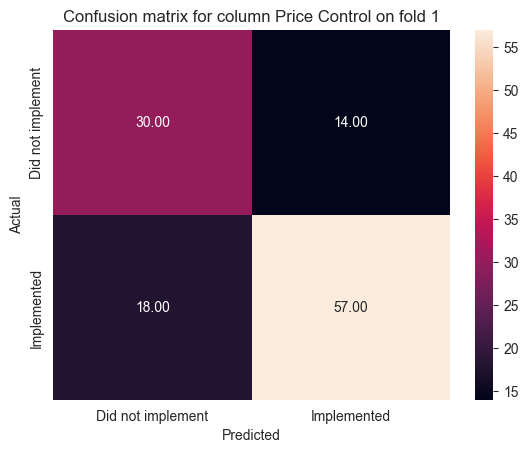

Precision: 0.8028169014084507
Recall: 0.76
f1 score: 0.7808219178082192
Log loss: 0.5499320550477633


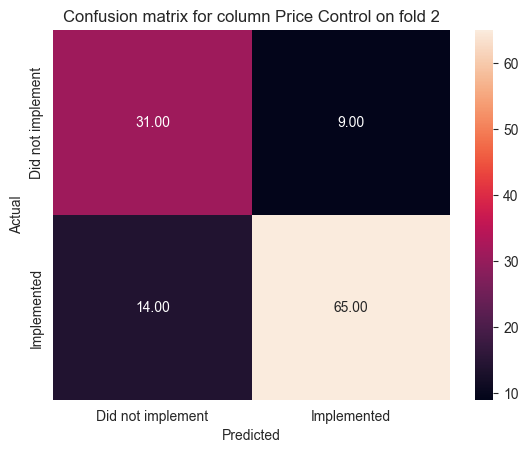

Precision: 0.8783783783783784
Recall: 0.8227848101265823
f1 score: 0.8496732026143792
Log loss: 0.46185025201011937


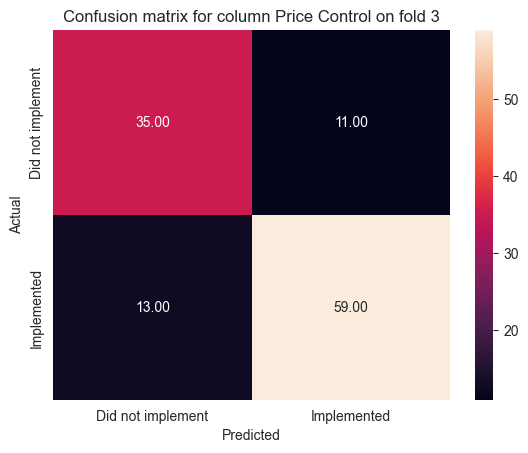

Precision: 0.8428571428571429
Recall: 0.8194444444444444
f1 score: 0.8309859154929577
Log loss: 0.44802530581129413


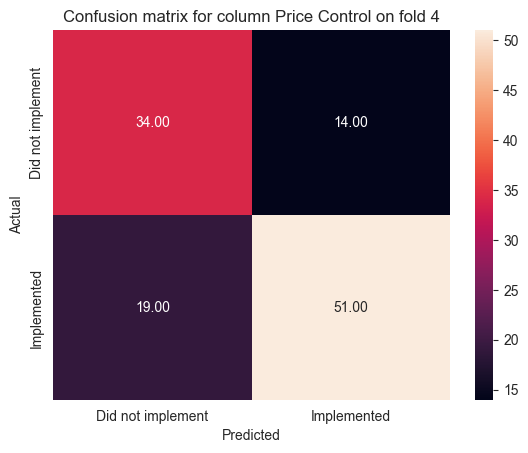

Precision: 0.7846153846153846
Recall: 0.7285714285714285
f1 score: 0.7555555555555555
Log loss: 0.48860869817694075


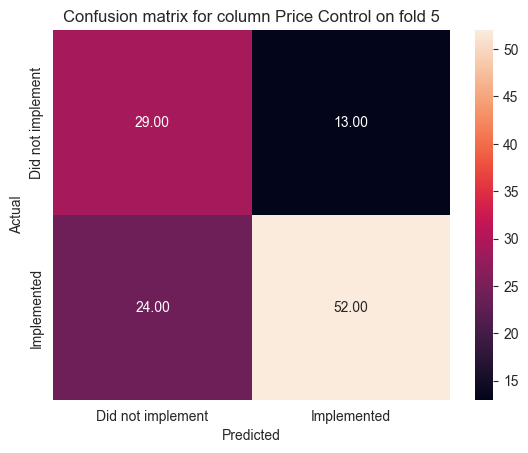

Precision: 0.8
Recall: 0.6842105263157895
f1 score: 0.7375886524822695
Log loss: 0.544309925242461
Average of precision scores: 0.8217335614518714
Average of recall scores: 0.7630022418916489
Average of f1 scores: 0.7909250487906763
Average of log loss scores: 0.49854524725771576
Tax Reduction


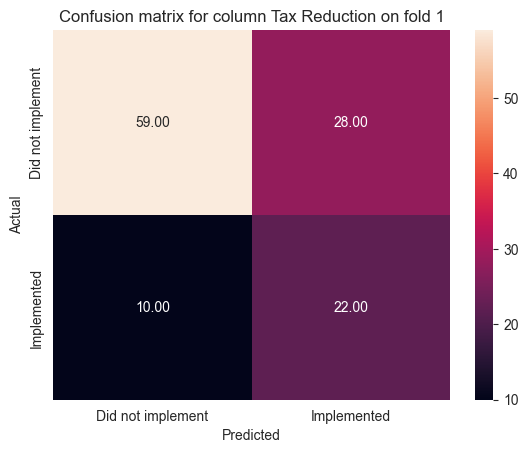

Precision: 0.44
Recall: 0.6875
f1 score: 0.5365853658536586
Log loss: 0.6450307743086977


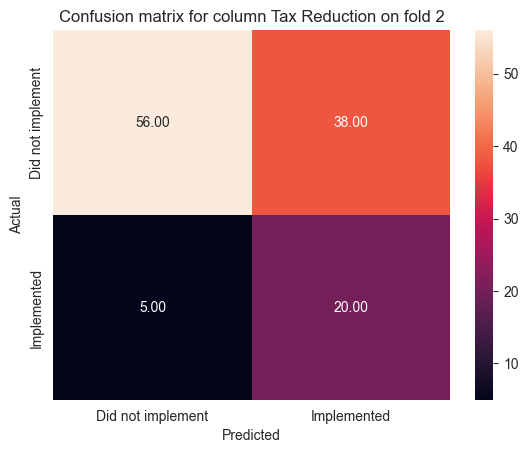

Precision: 0.3448275862068966
Recall: 0.8
f1 score: 0.48192771084337355
Log loss: 0.6550470598408421


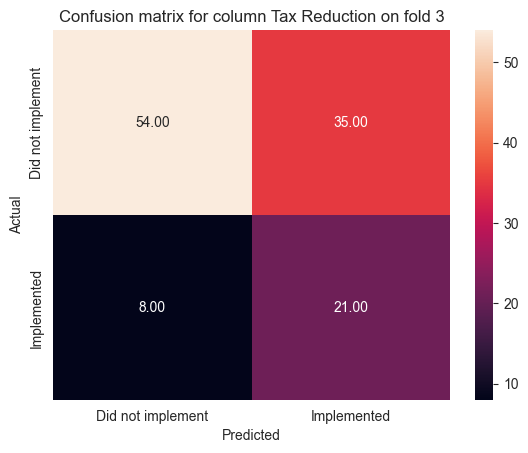

Precision: 0.375
Recall: 0.7241379310344828
f1 score: 0.4941176470588236
Log loss: 0.6465589826084651


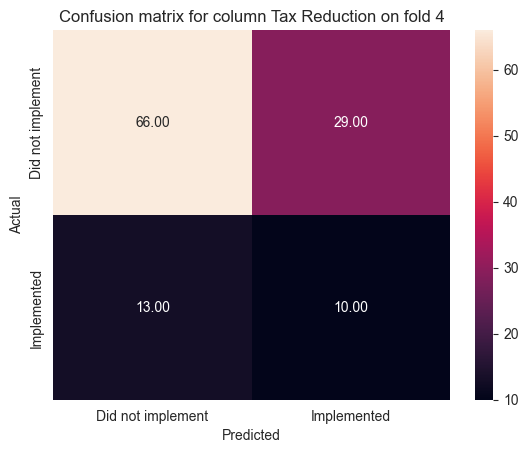

Precision: 0.2564102564102564
Recall: 0.43478260869565216
f1 score: 0.3225806451612903
Log loss: 0.6401019450490552


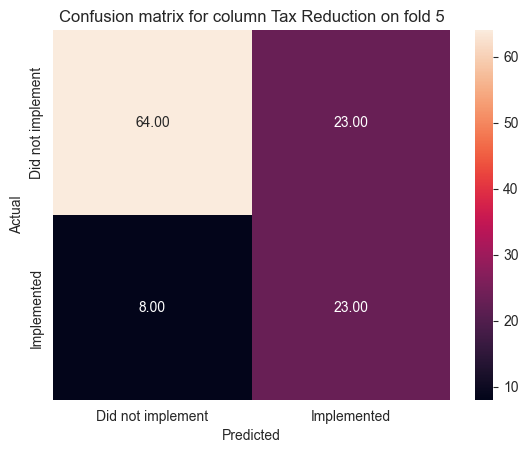

Precision: 0.5
Recall: 0.7419354838709677
f1 score: 0.5974025974025974
Log loss: 0.5857698601351214
Average of precision scores: 0.38324756852343056
Average of recall scores: 0.6776712047202207
Average of f1 scores: 0.48652279326394865
Average of log loss scores: 0.6345017243884363
No subsidy


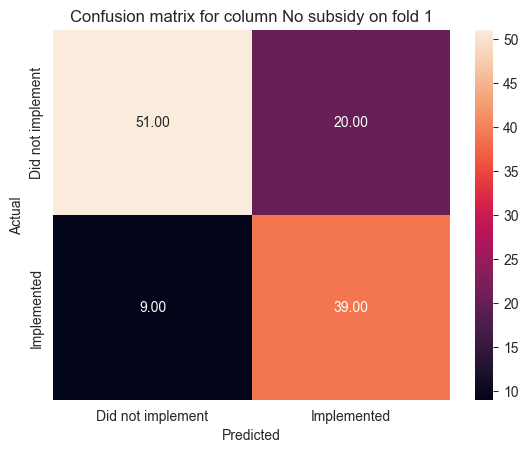

Precision: 0.6610169491525424
Recall: 0.8125
f1 score: 0.7289719626168225
Log loss: 0.524715395839709


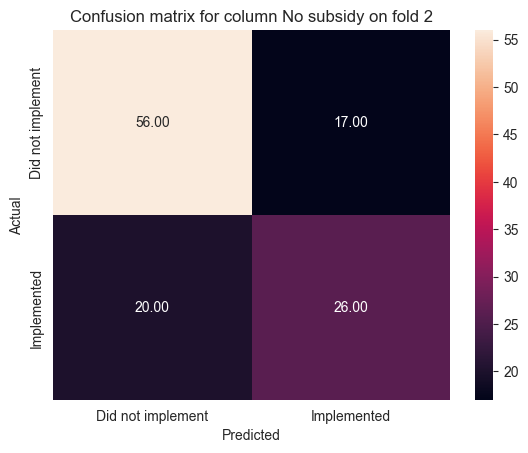

Precision: 0.6046511627906976
Recall: 0.5652173913043478
f1 score: 0.5842696629213482
Log loss: 0.5929265155804472


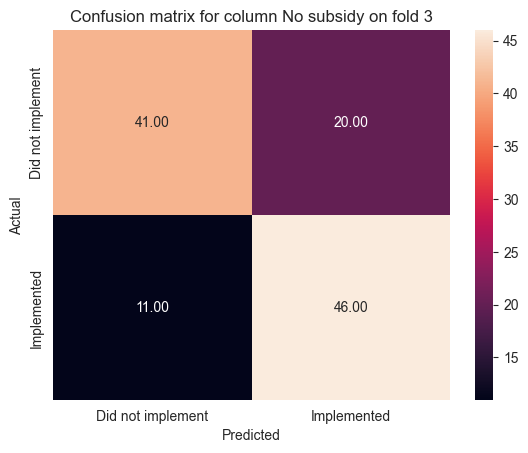

Precision: 0.696969696969697
Recall: 0.8070175438596491
f1 score: 0.7479674796747967
Log loss: 0.4978734465002241


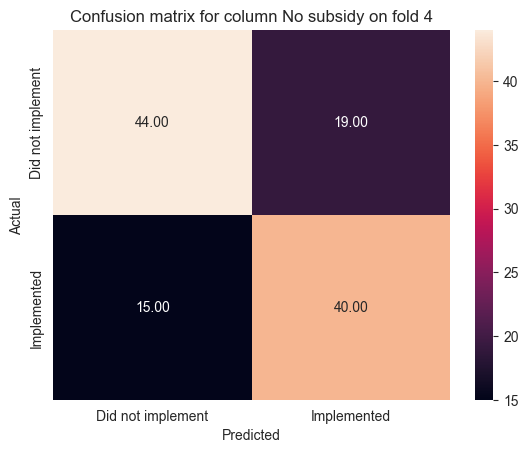

Precision: 0.6779661016949152
Recall: 0.7272727272727273
f1 score: 0.7017543859649122
Log loss: 0.5857624549959274


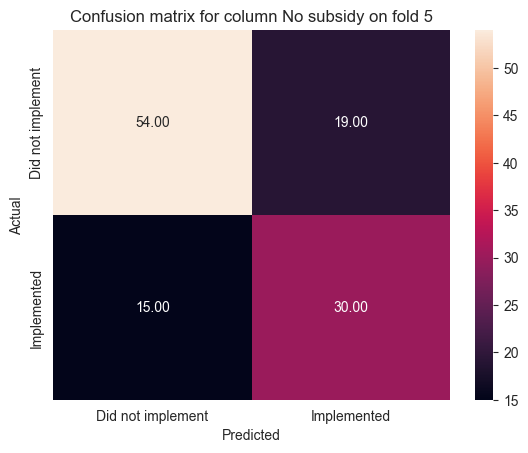

Precision: 0.6122448979591837
Recall: 0.6666666666666666
f1 score: 0.6382978723404255
Log loss: 0.5617506216602658
Average of precision scores: 0.6505697617134072
Average of recall scores: 0.7157348658206781
Average of f1 scores: 0.6802522727036611
Average of log loss scores: 0.5526056869153148
Some subsidy


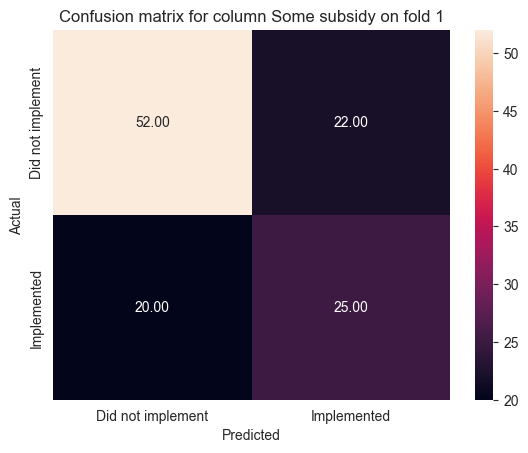

Precision: 0.5319148936170213
Recall: 0.5555555555555556
f1 score: 0.5434782608695652
Log loss: 0.648640244604353


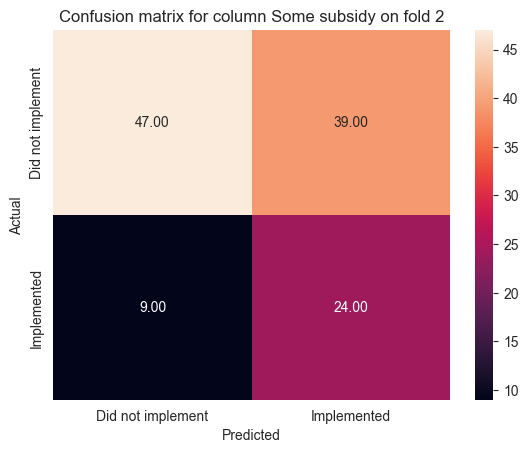

Precision: 0.38095238095238093
Recall: 0.7272727272727273
f1 score: 0.5
Log loss: 0.649589560413339


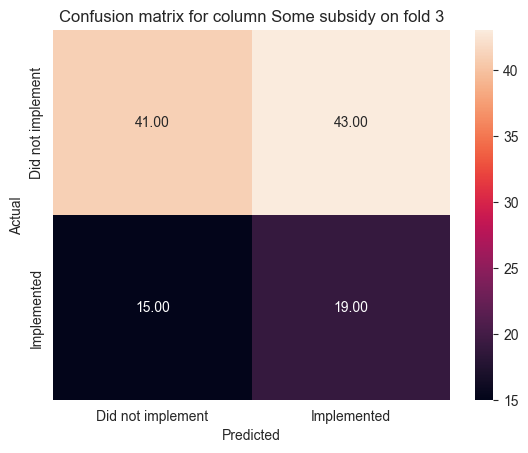

Precision: 0.3064516129032258
Recall: 0.5588235294117647
f1 score: 0.39583333333333337
Log loss: 0.7012568040175335


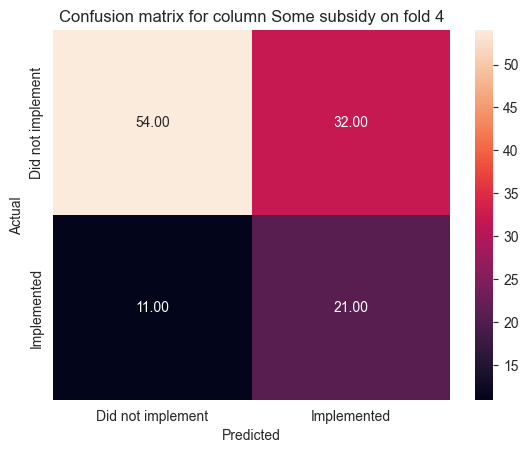

Precision: 0.39622641509433965
Recall: 0.65625
f1 score: 0.49411764705882355
Log loss: 0.667234788382101


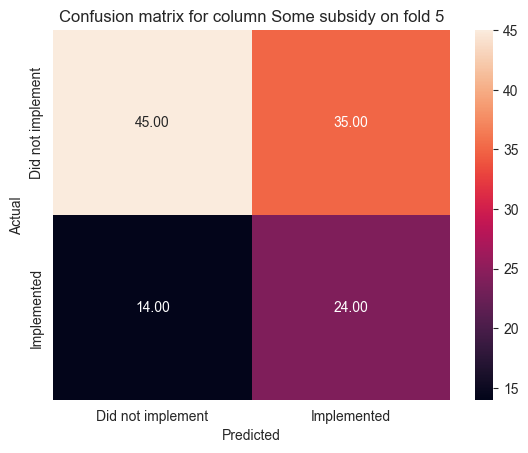

Precision: 0.4067796610169492
Recall: 0.631578947368421
f1 score: 0.4948453608247423
Log loss: 0.6608013975178094
Average of precision scores: 0.4044649927167834
Average of recall scores: 0.6258961519216937
Average of f1 scores: 0.48565492041729286
Average of log loss scores: 0.6655045589870272
Price freezes


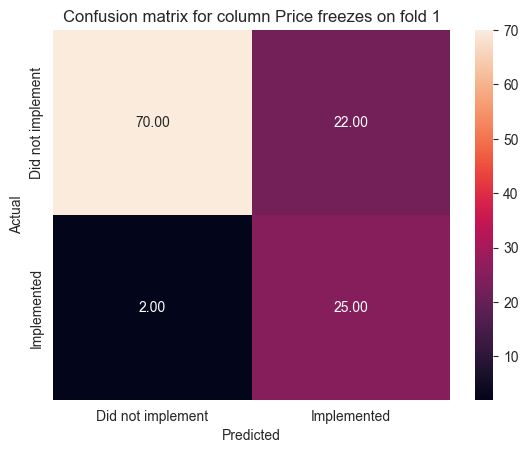

Precision: 0.5319148936170213
Recall: 0.9259259259259259
f1 score: 0.6756756756756757
Log loss: 0.44812603178973964


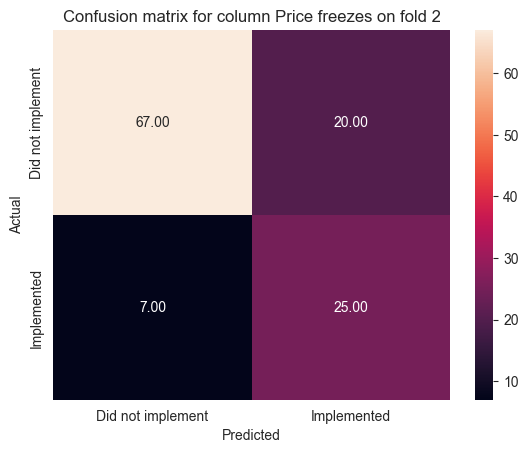

Precision: 0.5555555555555556
Recall: 0.78125
f1 score: 0.6493506493506493
Log loss: 0.4426800093303176


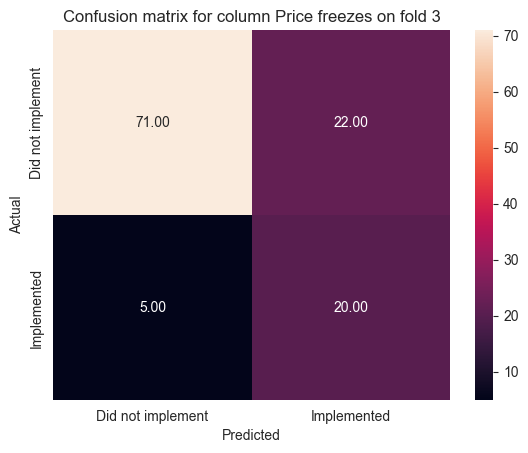

Precision: 0.47619047619047616
Recall: 0.8
f1 score: 0.5970149253731344
Log loss: 0.44210099861344543


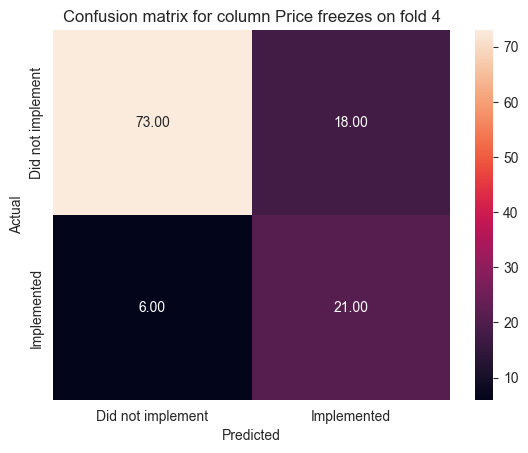

Precision: 0.5384615384615384
Recall: 0.7777777777777778
f1 score: 0.6363636363636364
Log loss: 0.49995700851527874


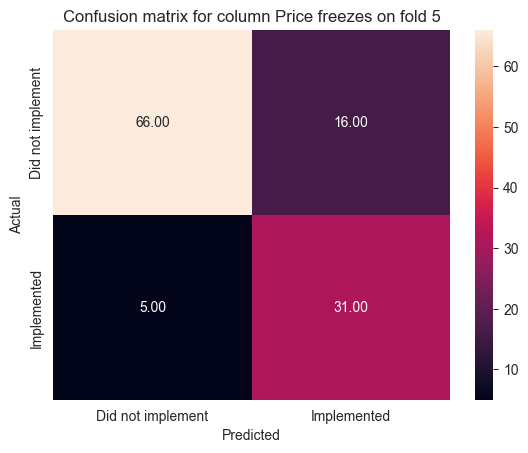

Precision: 0.6595744680851063
Recall: 0.8611111111111112
f1 score: 0.7469879518072289
Log loss: 0.3830103158465175
Average of precision scores: 0.5523393863819395
Average of recall scores: 0.8292129629629631
Average of f1 scores: 0.6610785677140649
Average of log loss scores: 0.4431748728190598


In [5]:
for year in range(2021,2025):
    basic_prediction_dataframes[year]['Country Code'] = basic_prediction_dataframes[year]['Country Code'].apply(lambda x: x + ' in ' + str(year))
combined_basic_data_with_index = pd.concat(list(basic_prediction_dataframes.values())).reset_index(drop=True)
#Removing index column
combined_basic_data = combined_basic_data_with_index.drop('Country Code', axis = 1)
x_columns = ['log_gdp data', 'log_population data', 'democracy index data', 'log_population density', 'Net Trade Status']
y_columns = ['Price Control', 'Tax Reduction', 'No subsidy', 'Some subsidy', 'Price freezes']

basic_regression_models = train_and_test_model(LogisticRegression(class_weight='balanced'), combined_basic_data, x_columns, y_columns)

Let's unpack what we just found. We trained the model for each output variable five times, with each fold being used as testing data for one round and training data for the other four. From the confusion matrices, we can see that the model performed better on some metrics than on others. When predicting price controls and price freezes, it does a decent job at differentiating between the outcomes on data it has never seen before, as the top left and bottom right corners of the confusion matrices (where the answer is correct) are where most of the data ends up. In other words, it is correct on most of the data. The average f1 score for the price control model was great, at around .8, while price freezes had an f1 score of .66, which shows the model is usable. In addition, the log loss is significantly lower than ln(2) or .693, for both of these. .693 is the value a model would get by simply assigning a probability of 1/2 to each outcome, or being maximally uncertain. For other categories, such as Tax reduction and Some subsidy, the model is only slightly better than chance, with more evenly distributed confusion matrices and log losses only slightly better than .693. In addition, these models have average f1 scores near .5, which means they are not good models.

Now that we trained the model, let's take a look at what inputs it determined were most important.


In [6]:
final_basic_regression_models = {}
standard_deviations = []
print("input variables:")
print(x_columns)
for col in x_columns:
    standard_dev = np.std(combined_basic_data[col])
    print(col + " standard deviation: " + str(standard_dev))
    standard_deviations.append(standard_dev)
for col in y_columns:
    final_basic_regression_models[col] = LogisticRegression(class_weight='balanced').fit(combined_basic_data[x_columns], combined_basic_data[col])
    print("model for " + col)
    print("Coefficients:")
    print(dict(zip(x_columns, final_basic_regression_models[col].coef_[0])))
    print("Intercept:")
    print(final_basic_regression_models[col].intercept_)
    importance = final_basic_regression_models[col].coef_ * standard_deviations
    print("importance of each x column:")
    print(dict(zip(x_columns, importance[0])))

input variables:
['log_gdp data', 'log_population data', 'democracy index data', 'log_population density', 'Net Trade Status']
log_gdp data standard deviation: 0.6131823307705104
log_population data standard deviation: 0.770839211817471
democracy index data standard deviation: 2.282305420673565
log_population density standard deviation: 0.5964940827739023
Net Trade Status standard deviation: 0.4116634111277789
model for Price Control
Coefficients:
{'log_gdp data': -1.704176104364015, 'log_population data': -0.961152411803642, 'democracy index data': -0.3377861945170676, 'log_population density': 0.3043793576751819, 'Net Trade Status': 0.38083483151338066}
Intercept:
[14.47193577]
importance of each x column:
{'log_gdp data': -1.0449706757173354, 'log_population data': -0.7408939675511806, 'democracy index data': -0.7709312627749986, 'log_population density': 0.18156048577176717, 'Net Trade Status': 0.15677576581707123}
model for Tax Reduction
Coefficients:
{'log_gdp data': 0.6686638552

)It looks like the model found the same correlations we found, in addition to some others. Similarly to our manual analysis, the model found that poorer countries are more likely to implement price controls, but it also found that smaller and less democratic countries are more likely to implement them. Again aligning with the manual analysis, it finds that wealthy countries are more likely to implement tax reductions. As for subsidies, the model finds that poorer, smaller, and less democratic countries are more likely to implement price freezing, and that price freezes are also more common for net exporters. Finally, subsidies are the one variable that goes against the general trend, becoming more likely as a country gets poorer, but also more likely as it gets larger and more democratic.

With this done, we will use the full models to make predictions on the data. These predictions will be on the data it was trained on, so any increased accuracy is likely a result of overfitting. Then, we will export both the model and the predictions it made, so that these are saved permanently as an end result. After this, we will make a random forest model with this same data, following a very similar process. We will see how this model performs compared to the regression model.


In [7]:
def use_and_save_models(inputs_with_index, outputs, models, model_name):
    inputs = inputs_with_index.drop('Country Code', axis = 1)
    outputs_actual = outputs
    outputs_actual.rename(columns = lambda x: 'Actual ' + x, inplace = True)
    outputs_predicted = pd.DataFrame()
    probabilities_predicted = pd.DataFrame()
    for output_var,model in models.items():
        outputs_predicted['Predicted ' + output_var] = model.predict(inputs)
        probabilities_predicted['Probability predicted ' + output_var] = model.predict_proba(inputs).T[1]
        with open('../models/' + model_name + output_var + '.pkl','wb') as file:
            pickle.dump(model, file)
    dataframe_tosave = pd.concat([inputs_with_index, outputs_actual, outputs_predicted, probabilities_predicted], axis =1)
    dataframe_tosave.to_csv('../final_predictions/' + model_name + '_predictions.csv')


Now, we will use the function on the regression models, and then train random forests.

In [8]:
inputs = combined_basic_data_with_index[['Country Code'] + x_columns].copy()
outputs = combined_basic_data[y_columns].copy()
models = final_basic_regression_models.copy()
use_and_save_models(inputs, outputs, models, 'basic_regression_model')

Price Control


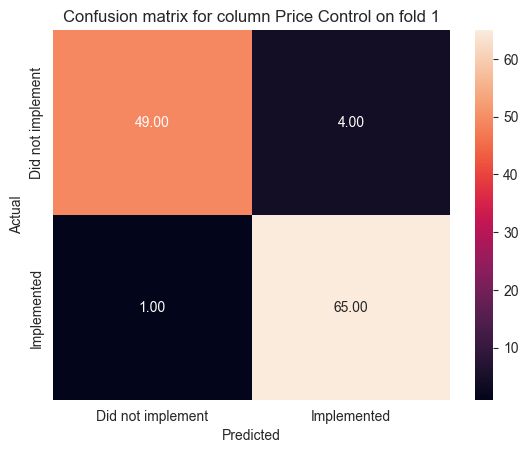

Precision: 0.9420289855072463
Recall: 0.9848484848484849
f1 score: 0.962962962962963
Log loss: 0.18344297804886464


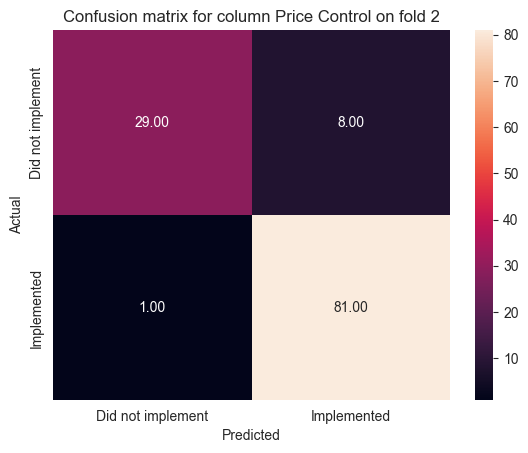

Precision: 0.9101123595505618
Recall: 0.9878048780487805
f1 score: 0.9473684210526315
Log loss: 0.47347571631310187


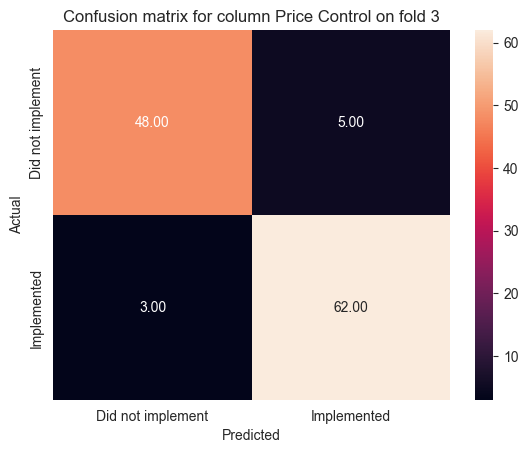

Precision: 0.9253731343283582
Recall: 0.9538461538461539
f1 score: 0.9393939393939394
Log loss: 0.1718410729149042


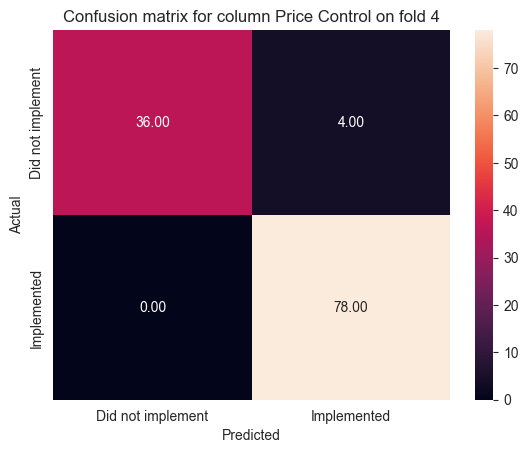

Precision: 0.9512195121951219
Recall: 1.0
f1 score: 0.975
Log loss: 0.12940443945419589


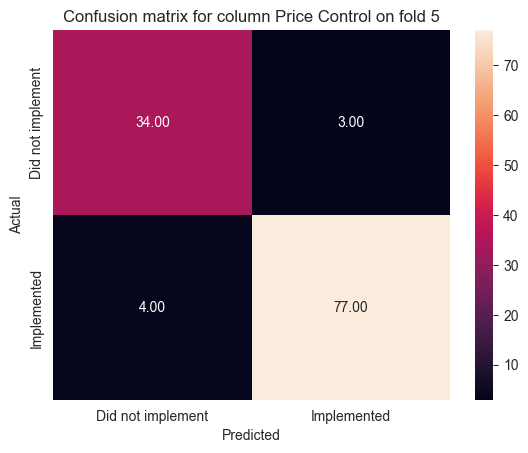

Precision: 0.9625
Recall: 0.9506172839506173
f1 score: 0.9565217391304348
Log loss: 0.20812717207580725
Average of precision scores: 0.9382467983162577
Average of recall scores: 0.9754233601388073
Average of f1 scores: 0.9562494125079939
Average of log loss scores: 0.23325827576137476
Tax Reduction


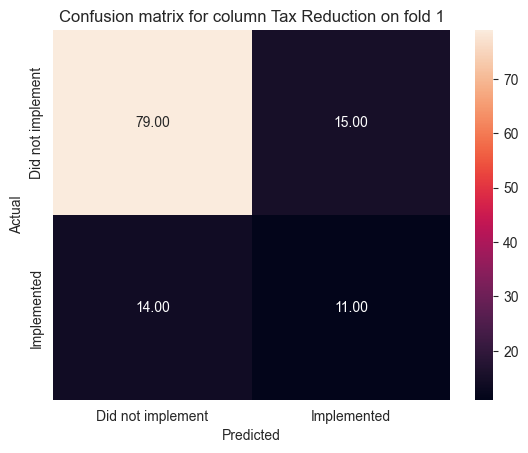

Precision: 0.4230769230769231
Recall: 0.44
f1 score: 0.4313725490196078
Log loss: 0.4518163491375142


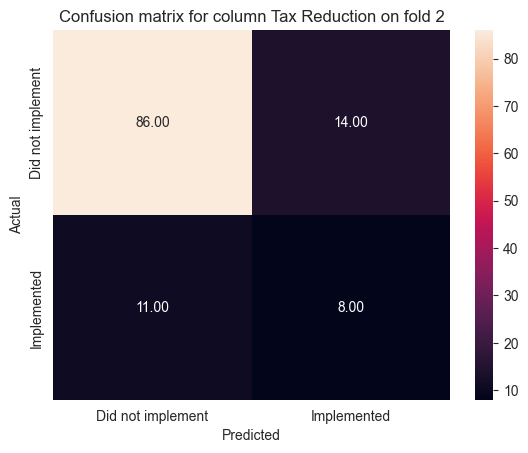

Precision: 0.36363636363636365
Recall: 0.42105263157894735
f1 score: 0.3902439024390244
Log loss: 0.4029525371281193


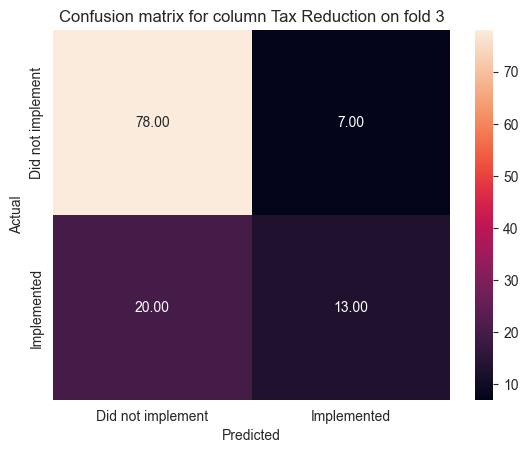

Precision: 0.65
Recall: 0.3939393939393939
f1 score: 0.490566037735849
Log loss: 0.7913915464939028


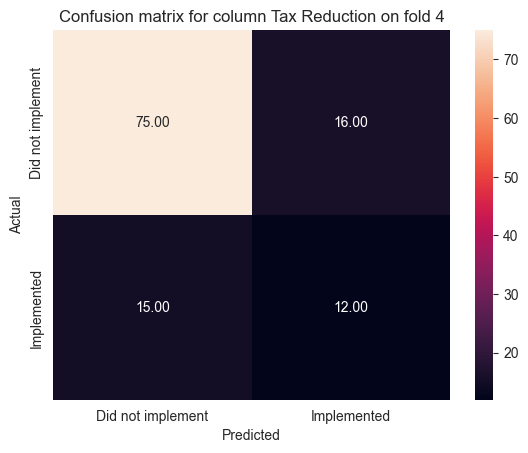

Precision: 0.42857142857142855
Recall: 0.4444444444444444
f1 score: 0.43636363636363634
Log loss: 0.4787476259807721


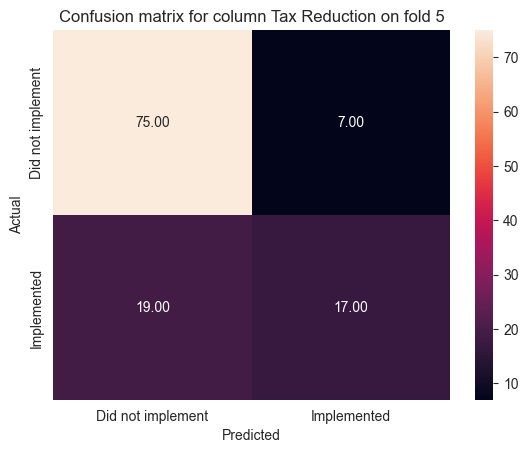

Precision: 0.7083333333333334
Recall: 0.4722222222222222
f1 score: 0.5666666666666667
Log loss: 0.48520587454320585
Average of precision scores: 0.5147236097236096
Average of recall scores: 0.43433173843700157
Average of f1 scores: 0.46304255844495684
Average of log loss scores: 0.5220227866567029
No subsidy


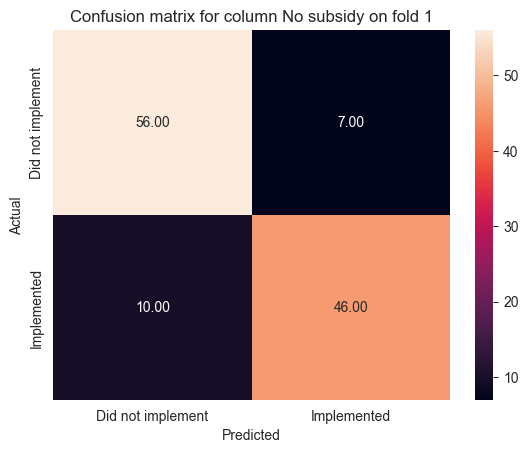

Precision: 0.8679245283018868
Recall: 0.8214285714285714
f1 score: 0.8440366972477065
Log loss: 0.6834576545464062


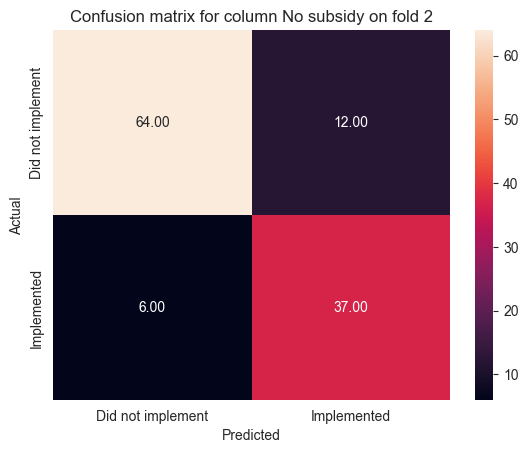

Precision: 0.7551020408163265
Recall: 0.8604651162790697
f1 score: 0.8043478260869564
Log loss: 0.34686570139860384


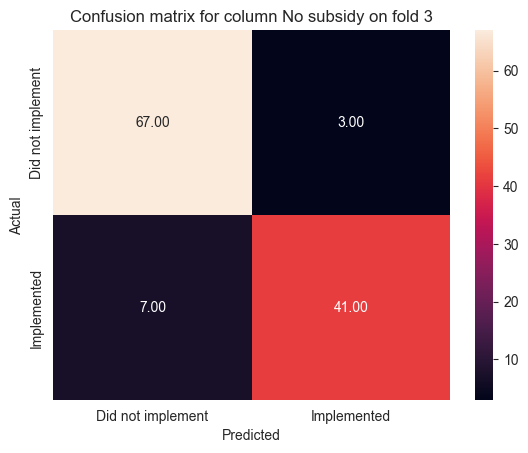

Precision: 0.9318181818181818
Recall: 0.8541666666666666
f1 score: 0.8913043478260869
Log loss: 0.2538965579005393


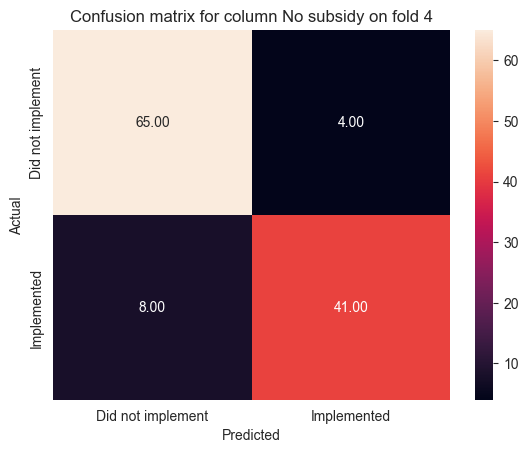

Precision: 0.9111111111111111
Recall: 0.8367346938775511
f1 score: 0.8723404255319148
Log loss: 0.2776901769071467


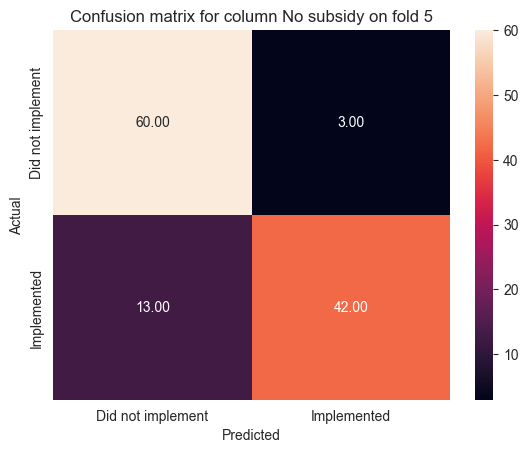

Precision: 0.9333333333333333
Recall: 0.7636363636363637
f1 score: 0.84
Log loss: 0.34197812864370203
Average of precision scores: 0.8798578390761678
Average of recall scores: 0.8272862823776445
Average of f1 scores: 0.8504058593385329
Average of log loss scores: 0.3807776438792796
Some subsidy


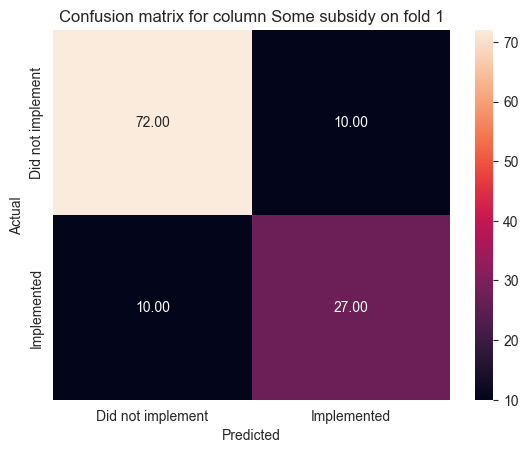

Precision: 0.7297297297297297
Recall: 0.7297297297297297
f1 score: 0.7297297297297297
Log loss: 0.6818239178237331


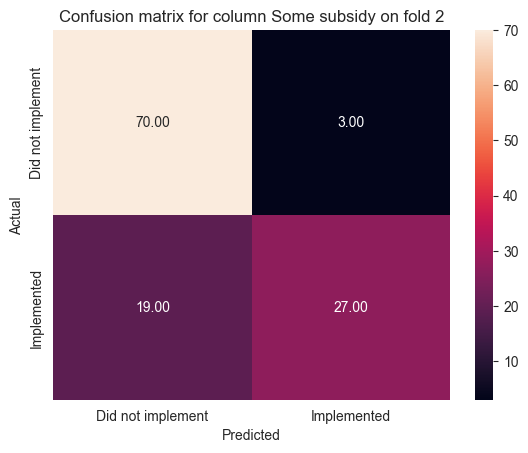

Precision: 0.9
Recall: 0.5869565217391305
f1 score: 0.7105263157894737
Log loss: 0.48330359858047134


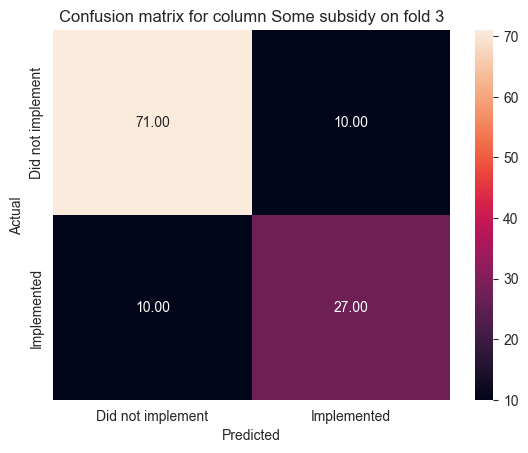

Precision: 0.7297297297297297
Recall: 0.7297297297297297
f1 score: 0.7297297297297297
Log loss: 0.6854012415695233


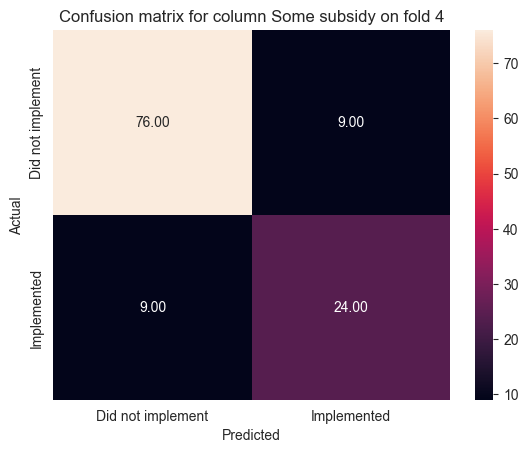

Precision: 0.7272727272727273
Recall: 0.7272727272727273
f1 score: 0.7272727272727273
Log loss: 0.3801342818441973


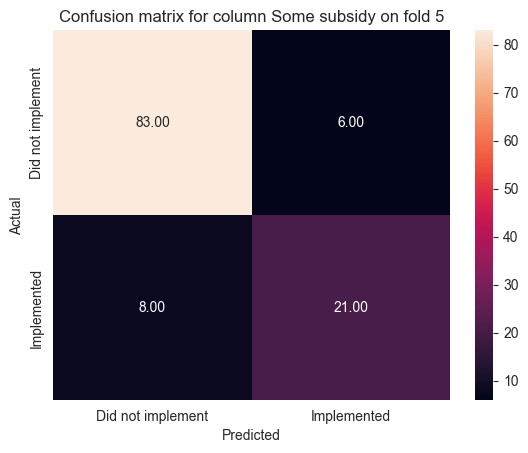

Precision: 0.7777777777777778
Recall: 0.7241379310344828
f1 score: 0.75
Log loss: 0.2967442325032867
Average of precision scores: 0.7729019929019929
Average of recall scores: 0.69956532790116
Average of f1 scores: 0.7294517005043322
Average of log loss scores: 0.5054814544642423
Price freezes


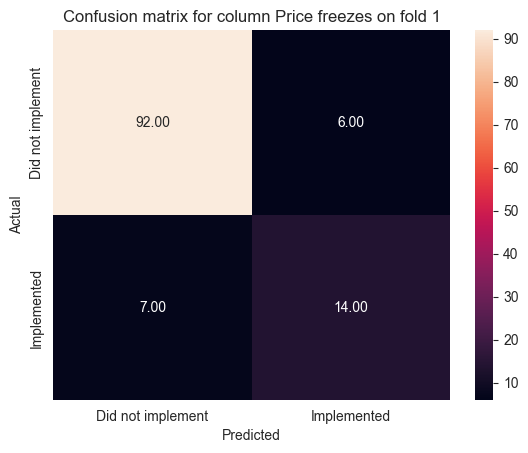

Precision: 0.7
Recall: 0.6666666666666666
f1 score: 0.6829268292682926
Log loss: 0.48499543776398424


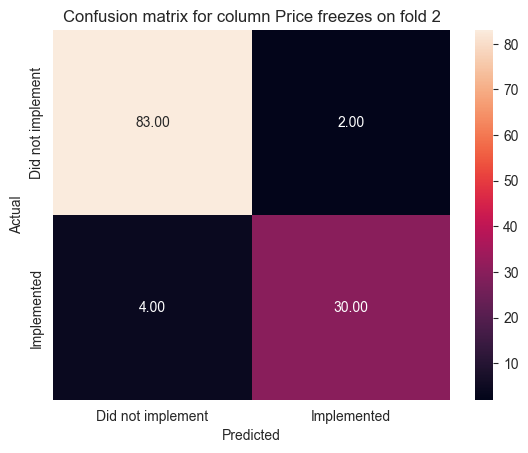

Precision: 0.9375
Recall: 0.8823529411764706
f1 score: 0.9090909090909091
Log loss: 0.4470515240264635


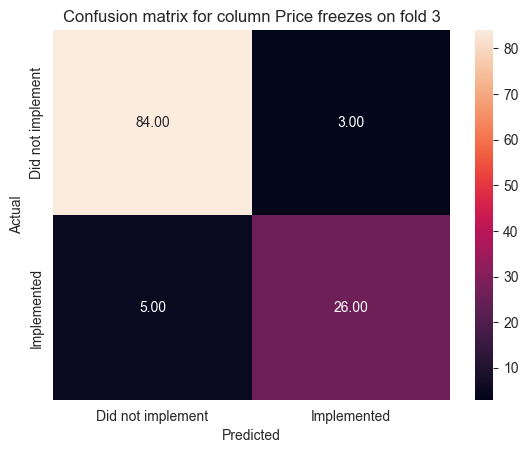

Precision: 0.896551724137931
Recall: 0.8387096774193549
f1 score: 0.8666666666666666
Log loss: 0.1915842196531875


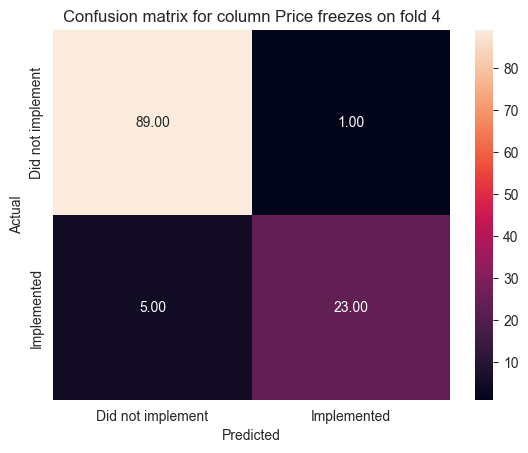

Precision: 0.9583333333333334
Recall: 0.8214285714285714
f1 score: 0.8846153846153847
Log loss: 0.47016324825707645


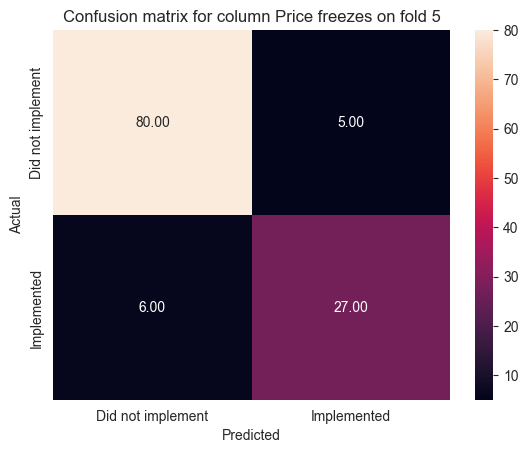

Precision: 0.84375
Recall: 0.8181818181818182
f1 score: 0.8307692307692308
Log loss: 0.1877667633409012
Average of precision scores: 0.8672270114942527
Average of recall scores: 0.8054679349745764
Average of f1 scores: 0.8348138040820967
Average of log loss scores: 0.3563122386083226


In [9]:
basic_random_forests = {}
basic_random_forests = train_and_test_model(RandomForestClassifier(class_weight='balanced'), combined_basic_data, x_columns, y_columns)

From this output, we can see that the random forest performs significantly better across all categories. The confusion matrices show significantly fewer mistakes, and the log loss is also significantly lower. f1 scores for price controls and price freezes have gone up to above .85, and the score for some subsidy, which was lower for the regression model, is now nearly .7. We will now look at the importance of each factor as determined by the model, and then save off this model and its predictions.

In [10]:
final_basic_random_forests = {}
for col in y_columns:
    final_basic_random_forests[col] = RandomForestClassifier(class_weight='balanced').fit(combined_basic_data[x_columns], combined_basic_data[col])
    print("importance's for predicting " + col)
    print((dict(zip(x_columns, final_basic_random_forests[col].feature_importances_))))


importance's for predicting Price Control
{'log_gdp data': 0.3173234975226354, 'log_population data': 0.22819135128943244, 'democracy index data': 0.27330416067386115, 'log_population density': 0.16427265579125017, 'Net Trade Status': 0.016908334722820894}
importance's for predicting Tax Reduction
{'log_gdp data': 0.26695477475231083, 'log_population data': 0.24524791987531425, 'democracy index data': 0.22935606896636176, 'log_population density': 0.23996290998625167, 'Net Trade Status': 0.018478326419761503}
importance's for predicting No subsidy
{'log_gdp data': 0.285239180829695, 'log_population data': 0.2112012940385292, 'democracy index data': 0.296999057945661, 'log_population density': 0.18942623456004118, 'Net Trade Status': 0.01713423262607372}
importance's for predicting Some subsidy
{'log_gdp data': 0.27438203410584455, 'log_population data': 0.21366526672892763, 'democracy index data': 0.22893299998678832, 'log_population density': 0.2647995051524027, 'Net Trade Status': 0.

Here, we see somewhat similar results to the importance seen in the regression model, although it seems like we've lost some nuance. All output variables show some importance for gdp, population, democracy index, and population density. A country's net import status seems to have little predictive value here. The value that stands out the most is the large importance of the democracy index input for predicting price freezes. This does make intuitive sense, since less democratic countries, with fewer checks and balances in the government, will be more willing and able to implement sudden drastic measures such as price freezes.


After saving these models, we will be making models similar to these two, only with datasets also including columns on what a given country did in previous years.


In [11]:
inputs = combined_basic_data_with_index[['Country Code'] + x_columns].copy()
outputs = combined_basic_data[y_columns].copy()
models = final_basic_random_forests
use_and_save_models(inputs, outputs, models, 'basic_random_forest')

Columns: 
Index(['Country Code', 'Price Control in previous year',
       'Tax Reduction in previous year', 'No subsidy in previous year',
       'Some subsidy in previous year', 'Price freezes in previous year',
       'Net Trade Status', 'Price Control', 'Tax Reduction', 'No subsidy',
       'Some subsidy', 'Price freezes', 'log_gdp data', 'log_population data',
       'democracy index data', 'log_population density'],
      dtype='object')
Price Control


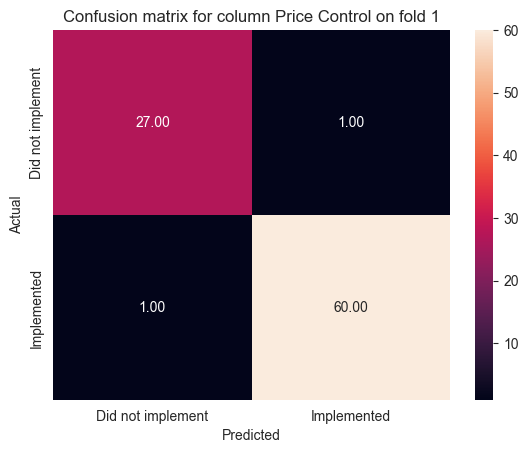

Precision: 0.9836065573770492
Recall: 0.9836065573770492
f1 score: 0.9836065573770492
Log loss: 0.1281796426557008


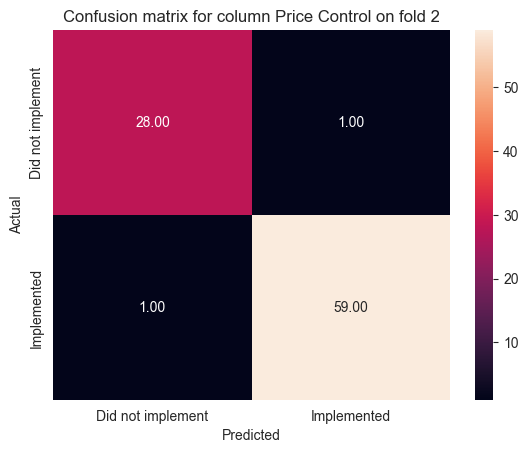

Precision: 0.9833333333333333
Recall: 0.9833333333333333
f1 score: 0.9833333333333333
Log loss: 0.11947538098641299


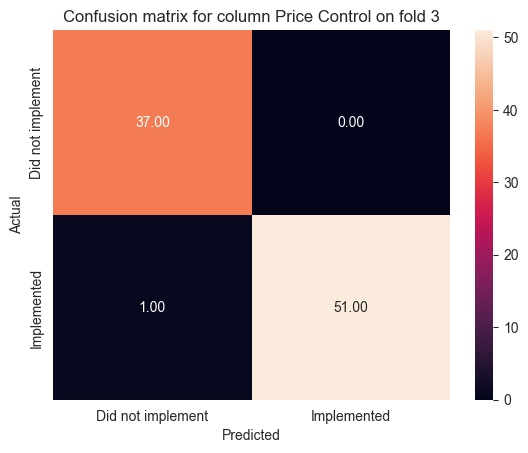

Precision: 1.0
Recall: 0.9807692307692307
f1 score: 0.9902912621359222
Log loss: 0.11878818356924024


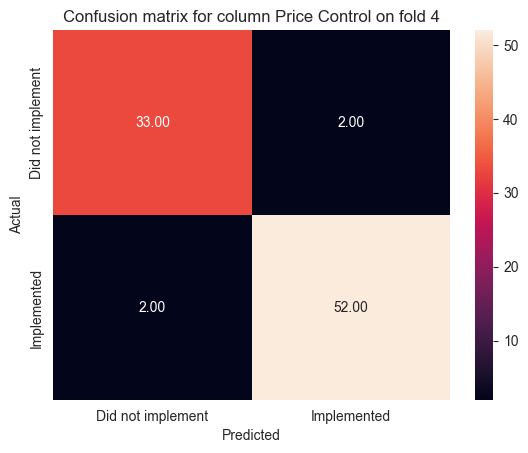

Precision: 0.9629629629629629
Recall: 0.9629629629629629
f1 score: 0.9629629629629629
Log loss: 0.17707187704979369


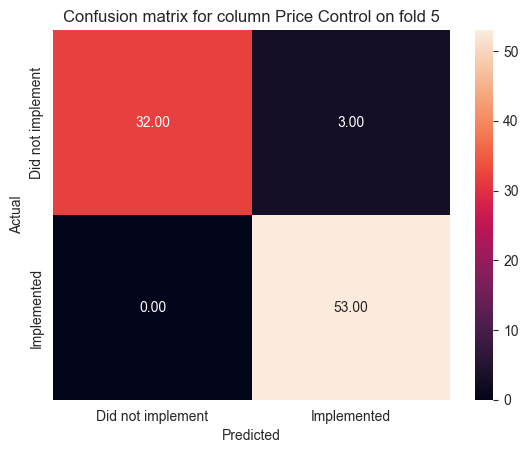

Precision: 0.9464285714285714
Recall: 1.0
f1 score: 0.9724770642201834
Log loss: 0.1349963171193904
Average of precision scores: 0.9752662850203834
Average of recall scores: 0.9821344168885151
Average of f1 scores: 0.9785342360058902
Average of log loss scores: 0.13570228027610762
Tax Reduction


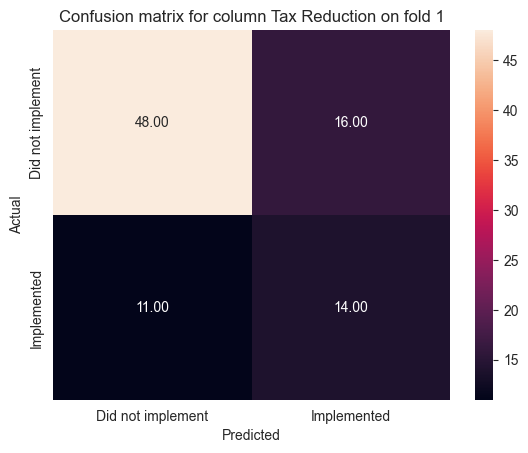

Precision: 0.4666666666666667
Recall: 0.56
f1 score: 0.509090909090909
Log loss: 0.6304847118766075


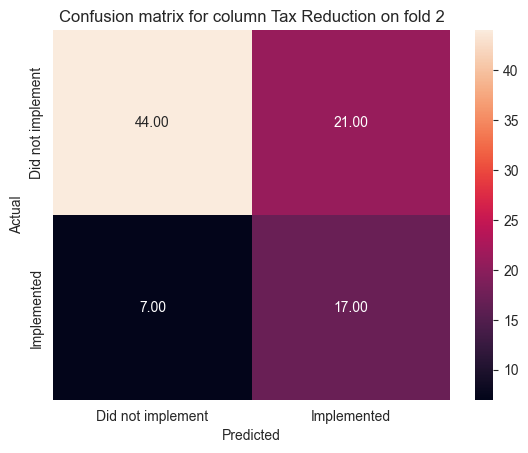

Precision: 0.4473684210526316
Recall: 0.7083333333333334
f1 score: 0.5483870967741936
Log loss: 0.5757216310743121


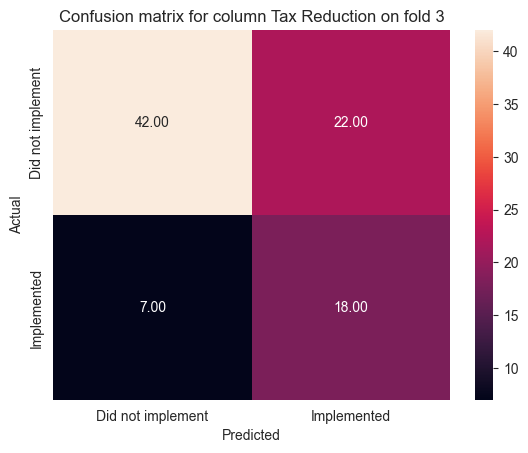

Precision: 0.45
Recall: 0.72
f1 score: 0.5538461538461539
Log loss: 0.5738625103231442


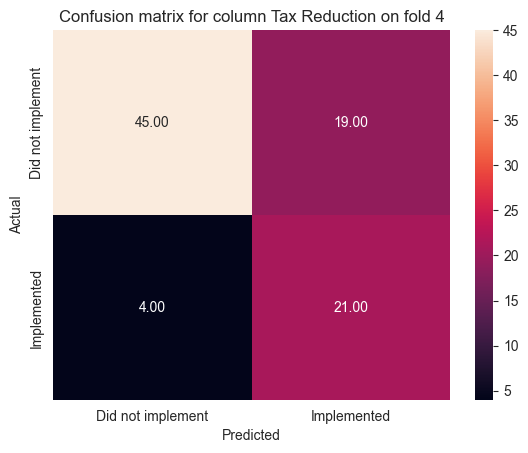

Precision: 0.525
Recall: 0.84
f1 score: 0.6461538461538462
Log loss: 0.5014551856135898


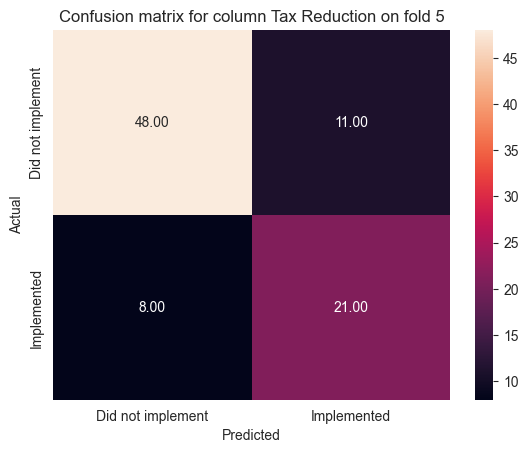

Precision: 0.65625
Recall: 0.7241379310344828
f1 score: 0.6885245901639345
Log loss: 0.49925290413890444
Average of precision scores: 0.5090570175438597
Average of recall scores: 0.7104942528735633
Average of f1 scores: 0.5892005192058075
Average of log loss scores: 0.5561553886053117
No subsidy


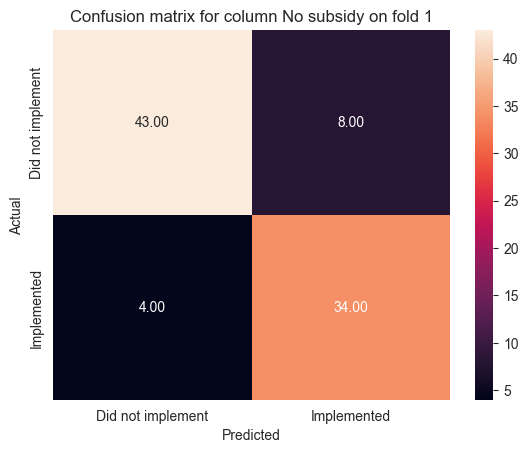

Precision: 0.8095238095238095
Recall: 0.8947368421052632
f1 score: 0.8500000000000001
Log loss: 0.3746723068801544


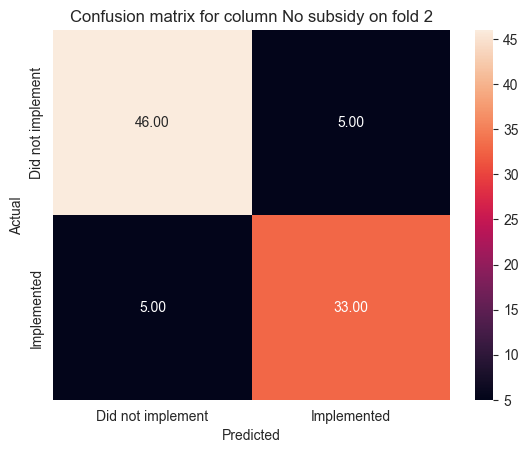

Precision: 0.868421052631579
Recall: 0.868421052631579
f1 score: 0.868421052631579
Log loss: 0.3137836281149936


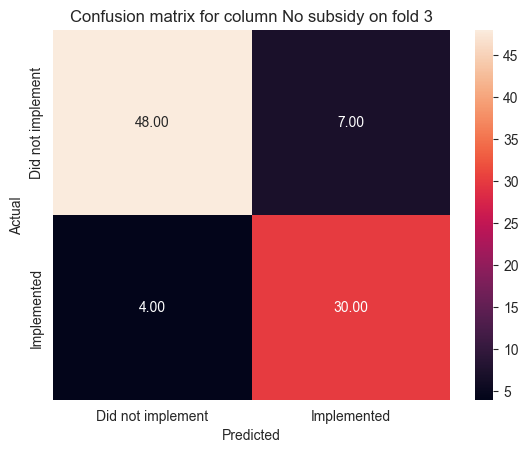

Precision: 0.8108108108108109
Recall: 0.8823529411764706
f1 score: 0.8450704225352113
Log loss: 0.33280508204263093


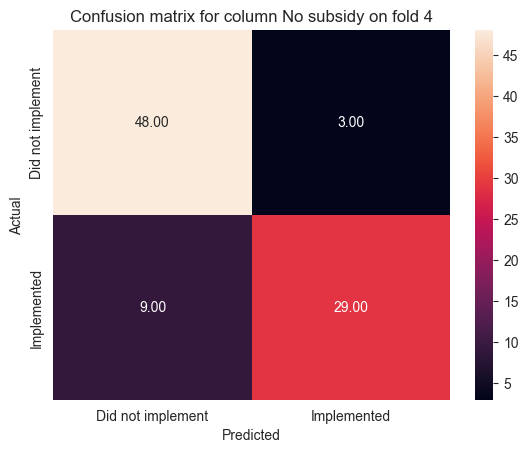

Precision: 0.90625
Recall: 0.7631578947368421
f1 score: 0.8285714285714286
Log loss: 0.3108326882570636


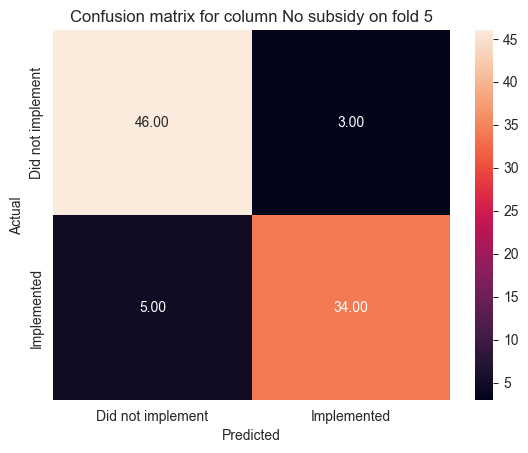

Precision: 0.918918918918919
Recall: 0.8717948717948718
f1 score: 0.8947368421052632
Log loss: 0.2942105759509132
Average of precision scores: 0.8627849183770238
Average of recall scores: 0.8560927204890053
Average of f1 scores: 0.8573599491686965
Average of log loss scores: 0.32526085624915113
Some subsidy


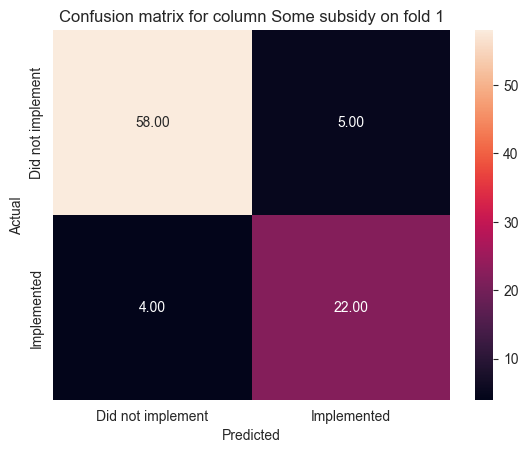

Precision: 0.8148148148148148
Recall: 0.8461538461538461
f1 score: 0.830188679245283
Log loss: 0.3537118252499092


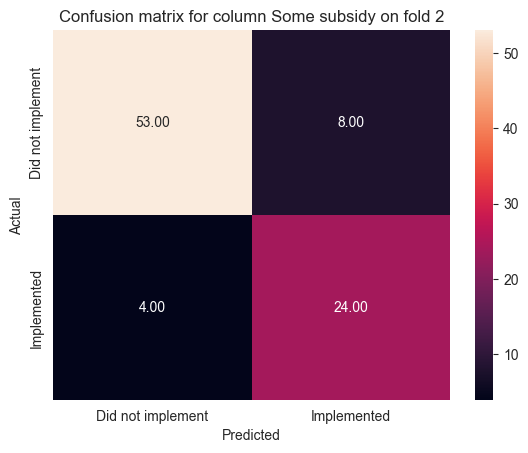

Precision: 0.75
Recall: 0.8571428571428571
f1 score: 0.7999999999999999
Log loss: 0.41016166062280923


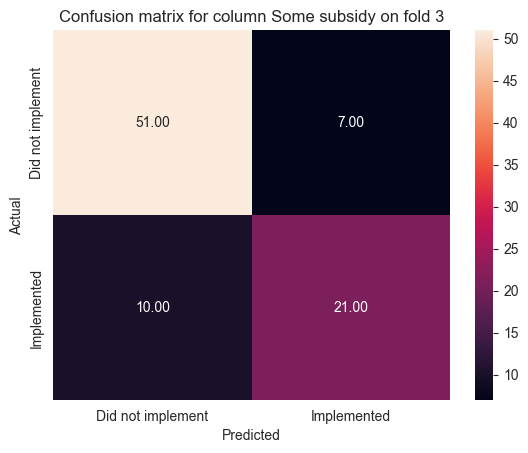

Precision: 0.75
Recall: 0.6774193548387096
f1 score: 0.7118644067796611
Log loss: 0.4729452151349398


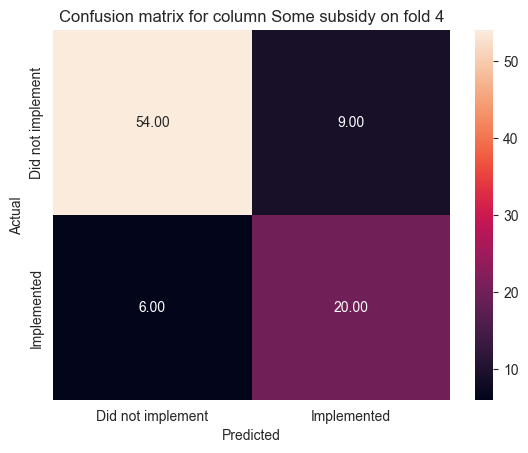

Precision: 0.6896551724137931
Recall: 0.7692307692307693
f1 score: 0.7272727272727274
Log loss: 0.47456939065727416


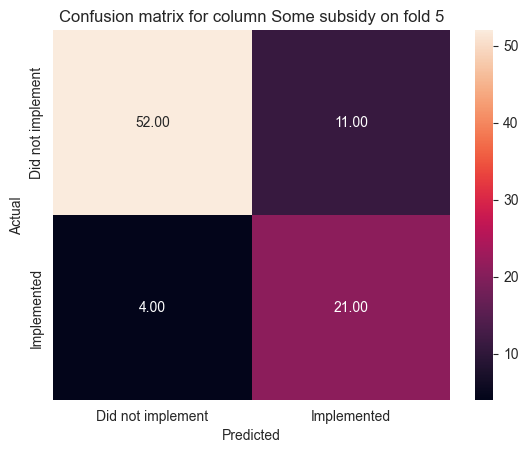

Precision: 0.65625
Recall: 0.84
f1 score: 0.736842105263158
Log loss: 0.4753633233906999
Average of precision scores: 0.7321439974457216
Average of recall scores: 0.7979893654732364
Average of f1 scores: 0.7612335837121659
Average of log loss scores: 0.43735028301112644
Price freezes


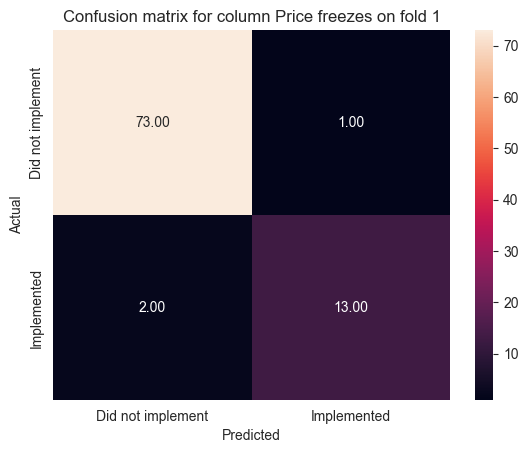

Precision: 0.9285714285714286
Recall: 0.8666666666666667
f1 score: 0.896551724137931
Log loss: 0.11623974292288863


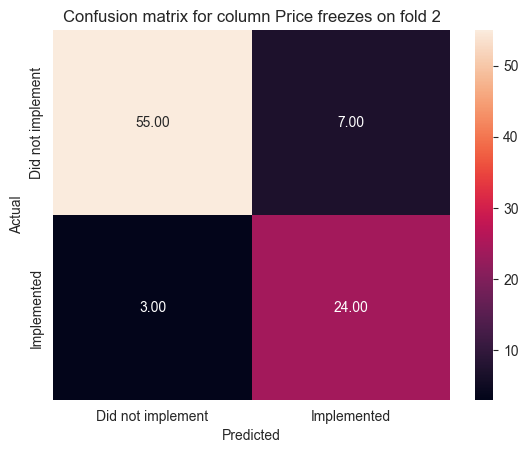

Precision: 0.7741935483870968
Recall: 0.8888888888888888
f1 score: 0.8275862068965517
Log loss: 0.35663765343717524


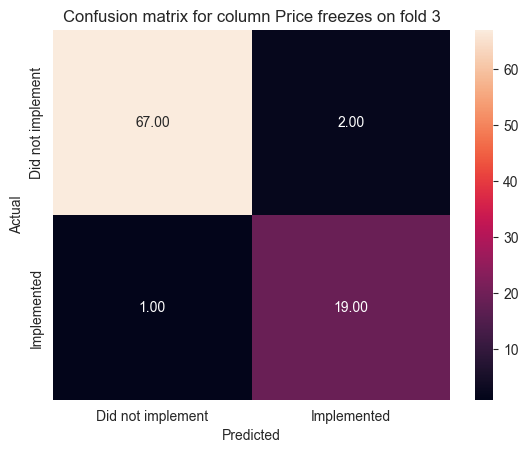

Precision: 0.9047619047619048
Recall: 0.95
f1 score: 0.9268292682926829
Log loss: 0.16744583640303343


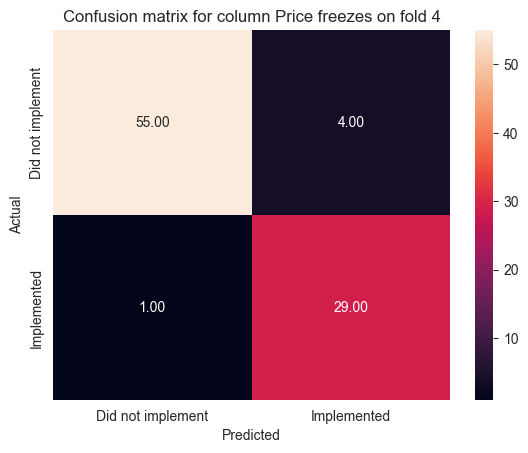

Precision: 0.8787878787878788
Recall: 0.9666666666666667
f1 score: 0.9206349206349207
Log loss: 0.20642403548667101


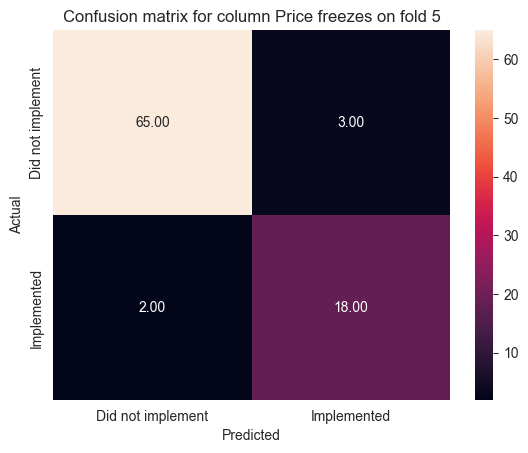

Precision: 0.8571428571428571
Recall: 0.9
f1 score: 0.8780487804878048
Log loss: 0.1753433869739326
Average of precision scores: 0.8686915235302332
Average of recall scores: 0.9144444444444446
Average of f1 scores: 0.8899301800899782
Average of log loss scores: 0.20441813104474021


In [12]:
combined_full_data_with_index = pd.concat(list(full_prediction_dataframes.values())).reset_index(drop=True)
print("Columns: ")
print(combined_full_data_with_index.columns)
#Removing index column
combined_full_data = combined_full_data_with_index.drop('Country Code', axis = 1)
x_columns = ['log_gdp data', 'log_population data', 'democracy index data', 'log_population density', 'Net Trade Status', 'Price Control in previous year', 'Tax Reduction in previous year', 'No subsidy in previous year', 'Some subsidy in previous year', 'Price freezes in previous year']
y_columns = ['Price Control', 'Tax Reduction', 'No subsidy', 'Some subsidy', 'Price freezes']

full_regression_models = train_and_test_model(LogisticRegression(max_iter=1000, class_weight='balanced'), combined_full_data, x_columns, y_columns)

As we expected, this model performs significantly better than the first regression model. The highly relevant input variables of past historical data more than made up for the smaller sample size that came from being able to use one fewer year of data. f1 scores for price controls and price freezes were above .9, and some sub subsidy had a score above .7. Now let's take a look at the importance of each feature. With data from prior years as an input, it will be interesting to see if the effect of the other inputs stays similar or not.

In [13]:
final_full_regression_models = {}
standard_deviations = []
print("input variables:")
print(x_columns)
for col in x_columns:
    standard_dev = np.std(combined_full_data[col])
    print(col + " Standard deviation: " + str(standard_dev))
    standard_deviations.append(standard_dev)
print(x_columns)
for col in y_columns:
    final_full_regression_models[col] = LogisticRegression(class_weight='balanced').fit(combined_full_data[x_columns], combined_full_data[col])
    print("model for " + col)
    print("Coefficients:")
    print(dict(zip(x_columns, final_full_regression_models[col].coef_[0])))
    print("Intercept:")
    print(final_full_regression_models[col].intercept_)
    importance = final_full_regression_models[col].coef_ * standard_deviations
    print("importance of each x column:")
    print(dict(zip(x_columns, importance)))

input variables:
['log_gdp data', 'log_population data', 'democracy index data', 'log_population density', 'Net Trade Status', 'Price Control in previous year', 'Tax Reduction in previous year', 'No subsidy in previous year', 'Some subsidy in previous year', 'Price freezes in previous year']
log_gdp data Standard deviation: 0.6150756977405115
log_population data Standard deviation: 0.7712700038329667
democracy index data Standard deviation: 2.30585056675282
log_population density Standard deviation: 0.5959121544877466
Net Trade Status Standard deviation: 0.4116634111277789
Price Control in previous year Standard deviation: 0.4813922467718075
Tax Reduction in previous year Standard deviation: 0.43809056399468377
No subsidy in previous year Standard deviation: 0.4891485391170533
Some subsidy in previous year Standard deviation: 0.47140452079103173
Price freezes in previous year Standard deviation: 0.4368440506822868
['log_gdp data', 'log_population data', 'democracy index data', 'log_pop

These weights give us a few more insights than what we saw from the last model. First, we can see that the importance of the basic input columns has mostly stayed constant, although sometimes it has gotten weaker. This makes sense, since as more variables are introduced, the effect of each one will be a smaller percentage of the total model. In addition, we see that the most important input is what the state of that given variable was in the previous year. This obviously makes sense, and is a good sign of the overall validity of the model. A couple other interesting insights come out. First, we can see that recurring price freezes and price controls are good predictors of each other, which makes sense, since these are similar practices. We also see that these are negatively correlated to tax reductions, likely because one is more common in poorer smaller dictatorships and the other is more common in wealthy, populated democracies.


Similarly to all the other models, we will now save off this model, and then we will proceed to training a random forest on this data.

In [14]:
inputs = combined_full_data_with_index[['Country Code'] + x_columns].copy()
outputs = combined_full_data[y_columns].copy()
models = final_full_regression_models
use_and_save_models(inputs, outputs, models, 'full_regression_model')

Price Control


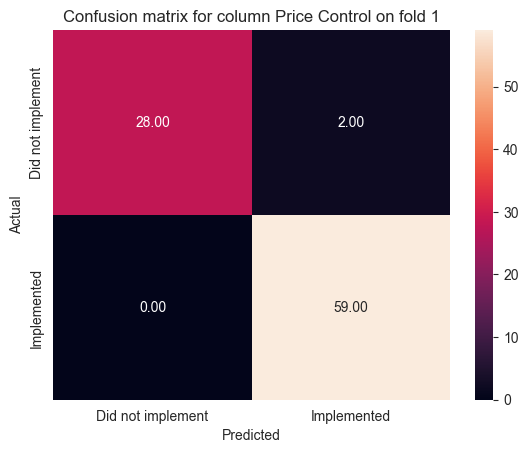

Precision: 0.9672131147540983
Recall: 1.0
f1 score: 0.9833333333333333
Log loss: 0.10231922712252055


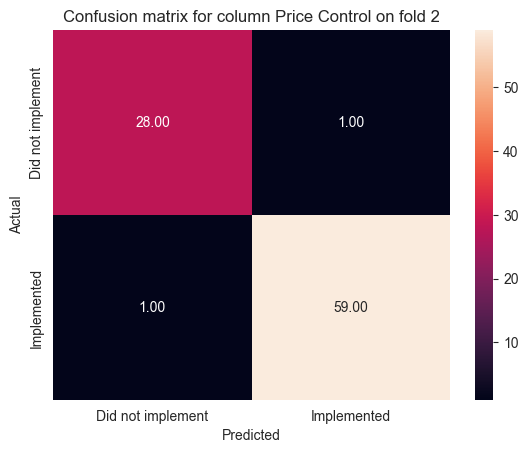

Precision: 0.9833333333333333
Recall: 0.9833333333333333
f1 score: 0.9833333333333333
Log loss: 0.07658076617966779


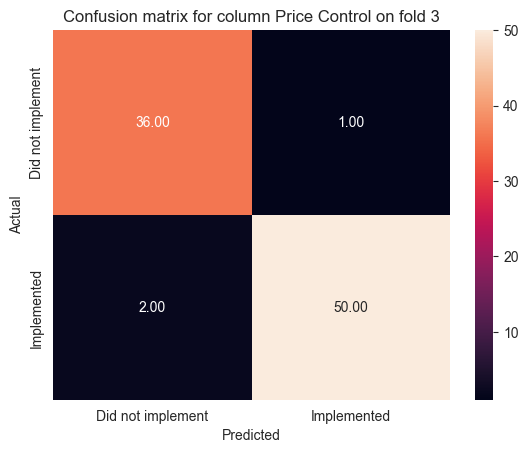

Precision: 0.9803921568627451
Recall: 0.9615384615384616
f1 score: 0.970873786407767
Log loss: 0.14166275366690498


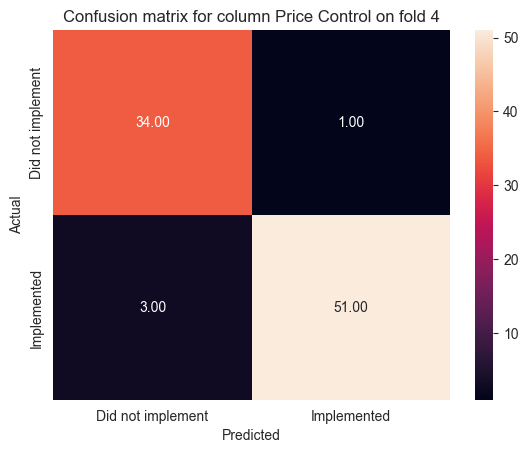

Precision: 0.9807692307692307
Recall: 0.9444444444444444
f1 score: 0.9622641509433962
Log loss: 0.1404226530913151


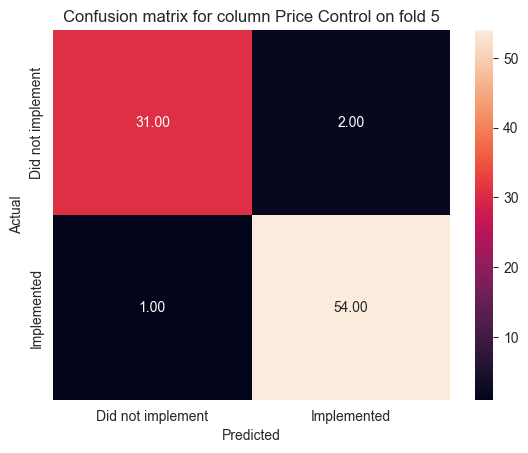

Precision: 0.9642857142857143
Recall: 0.9818181818181818
f1 score: 0.972972972972973
Log loss: 0.15920537192184703
Average of precision scores: 0.9751987100010243
Average of recall scores: 0.9742268842268842
Average of f1 scores: 0.9745555153981605
Average of log loss scores: 0.12403815439645109
Tax Reduction


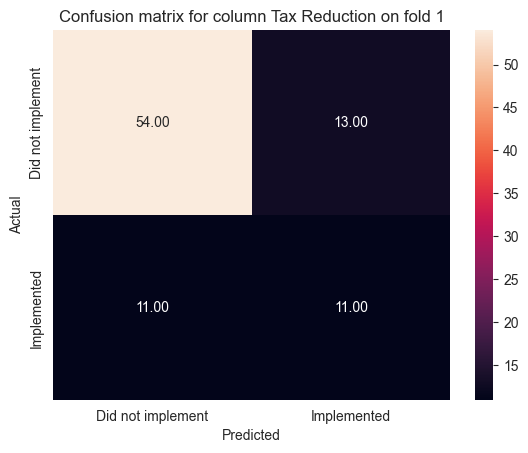

Precision: 0.4583333333333333
Recall: 0.5
f1 score: 0.4782608695652174
Log loss: 0.47496844126152504


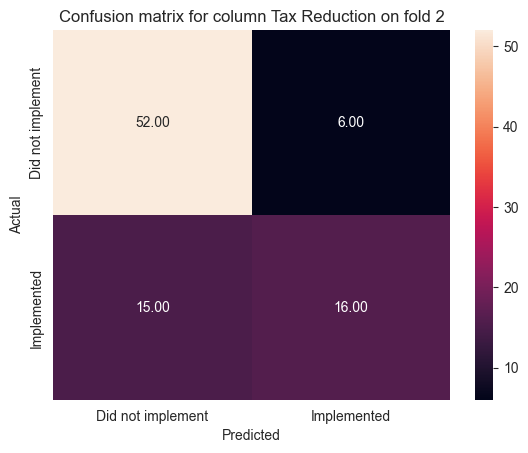

Precision: 0.7272727272727273
Recall: 0.5161290322580645
f1 score: 0.6037735849056604
Log loss: 0.43087466836331695


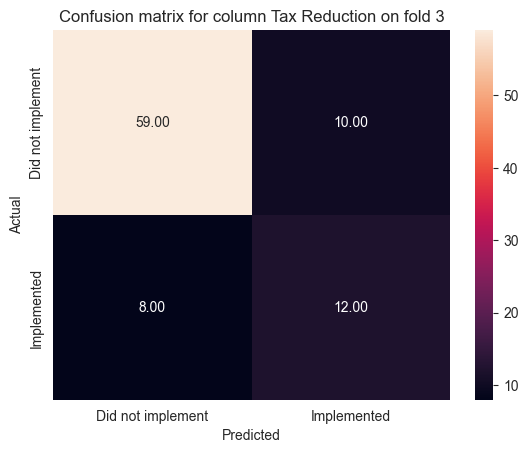

Precision: 0.5454545454545454
Recall: 0.6
f1 score: 0.5714285714285713
Log loss: 0.428962846957893


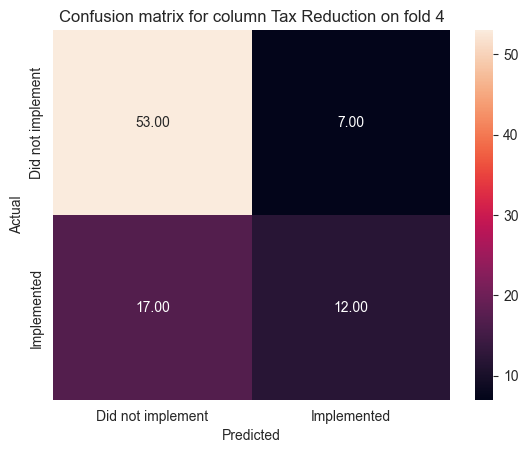

Precision: 0.631578947368421
Recall: 0.41379310344827586
f1 score: 0.5
Log loss: 0.5236294728281727


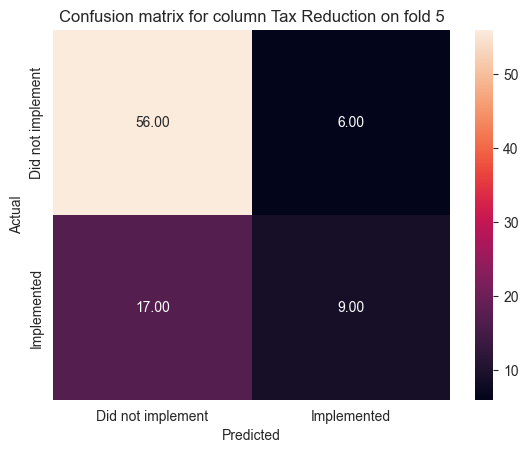

Precision: 0.6
Recall: 0.34615384615384615
f1 score: 0.43902439024390244
Log loss: 0.49304461699684266
Average of precision scores: 0.5925279106858053
Average of recall scores: 0.47521519637203735
Average of f1 scores: 0.5184974832286703
Average of log loss scores: 0.47029600928155013
No subsidy


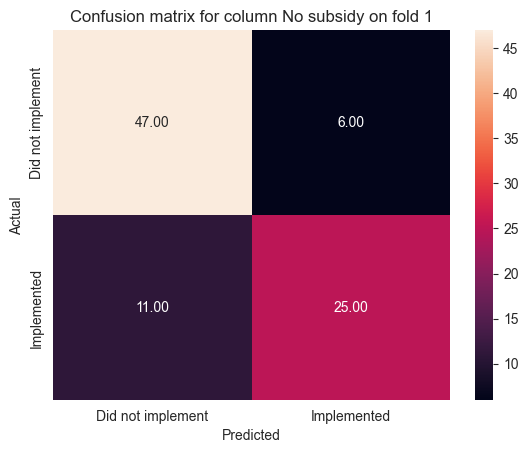

Precision: 0.8064516129032258
Recall: 0.6944444444444444
f1 score: 0.746268656716418
Log loss: 0.3988894741485919


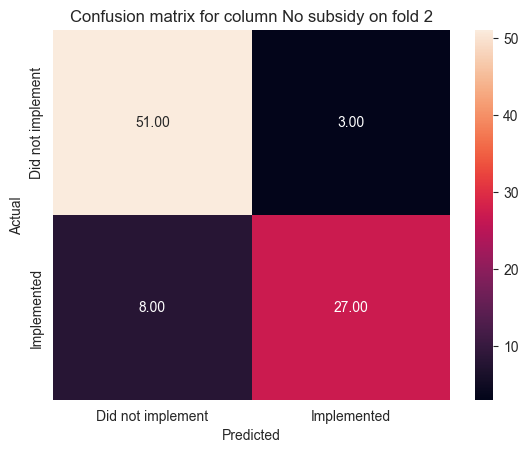

Precision: 0.9
Recall: 0.7714285714285715
f1 score: 0.8307692307692307
Log loss: 0.24003787948422495


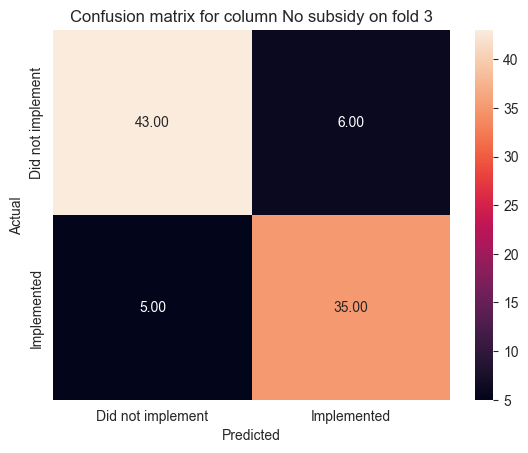

Precision: 0.8536585365853658
Recall: 0.875
f1 score: 0.8641975308641976
Log loss: 0.6641478097096679


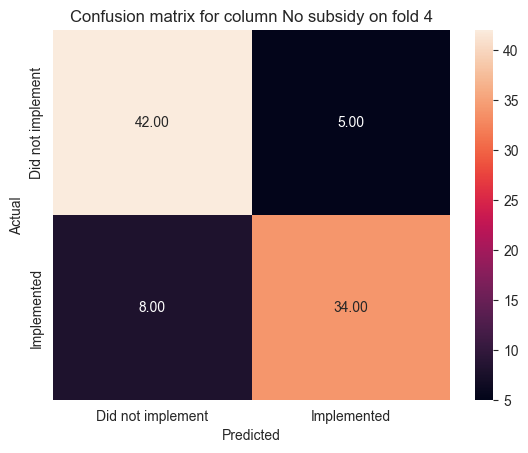

Precision: 0.8717948717948718
Recall: 0.8095238095238095
f1 score: 0.8395061728395062
Log loss: 0.3372622352346957


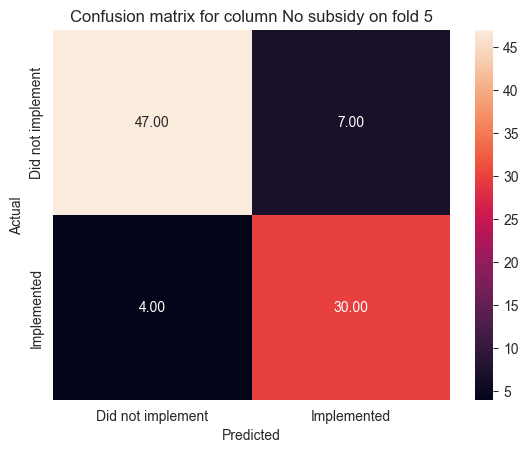

Precision: 0.8108108108108109
Recall: 0.8823529411764706
f1 score: 0.8450704225352113
Log loss: 0.2570538311508108
Average of precision scores: 0.8485431664188547
Average of recall scores: 0.8065499533146593
Average of f1 scores: 0.8251624027449127
Average of log loss scores: 0.3794782459455982
Some subsidy


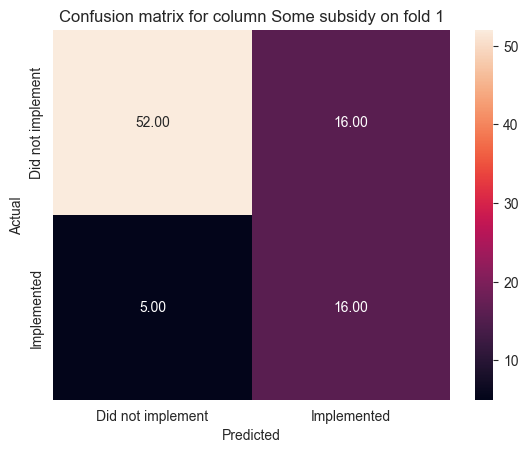

Precision: 0.5
Recall: 0.7619047619047619
f1 score: 0.6037735849056604
Log loss: 0.4001630434498711


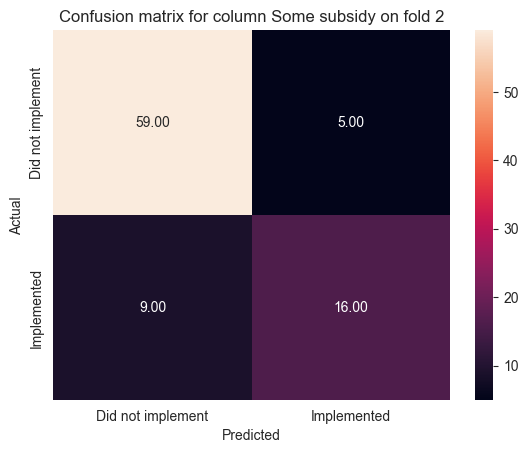

Precision: 0.7619047619047619
Recall: 0.64
f1 score: 0.6956521739130435
Log loss: 0.7037924267820251


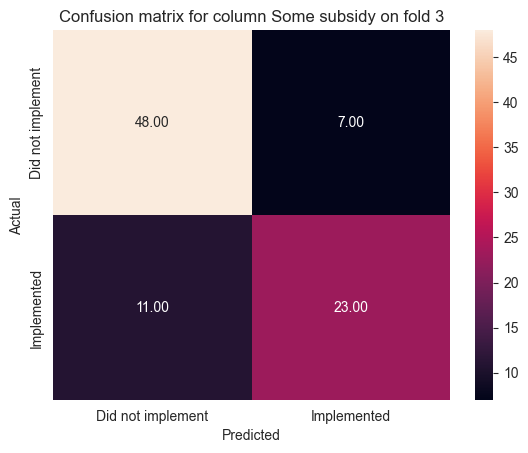

Precision: 0.7666666666666667
Recall: 0.6764705882352942
f1 score: 0.71875
Log loss: 0.5147926313238683


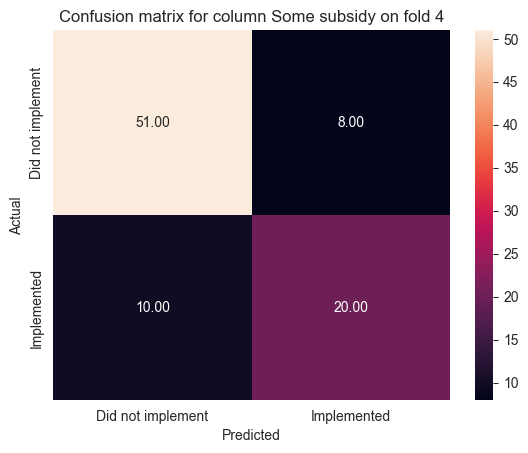

Precision: 0.7142857142857143
Recall: 0.6666666666666666
f1 score: 0.689655172413793
Log loss: 0.433550184111743


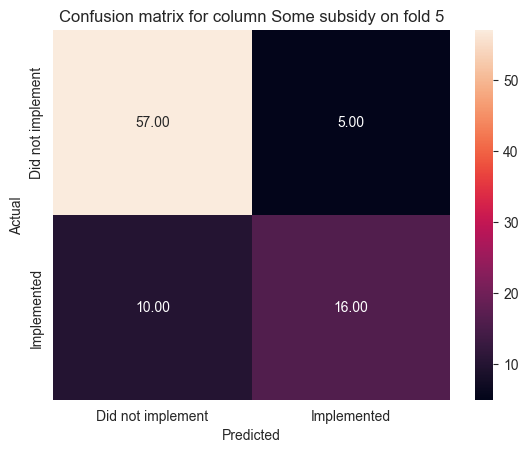

Precision: 0.7619047619047619
Recall: 0.6153846153846154
f1 score: 0.6808510638297872
Log loss: 0.3952255093654136
Average of precision scores: 0.700952380952381
Average of recall scores: 0.6720853264382676
Average of f1 scores: 0.6777363990124569
Average of log loss scores: 0.48950475900658424
Price freezes


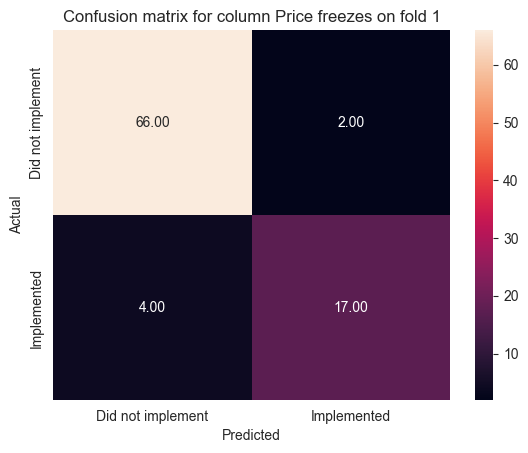

Precision: 0.8947368421052632
Recall: 0.8095238095238095
f1 score: 0.8500000000000001
Log loss: 0.19475138487366056


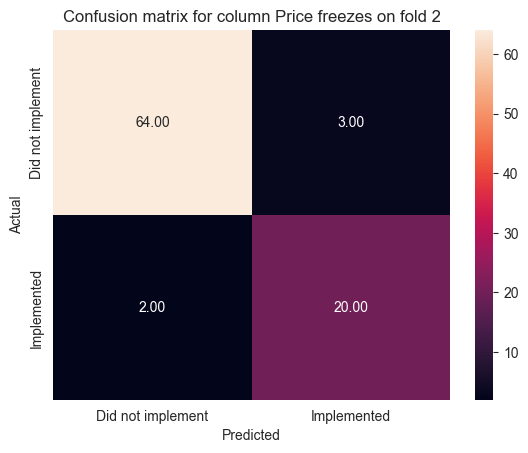

Precision: 0.8695652173913043
Recall: 0.9090909090909091
f1 score: 0.888888888888889
Log loss: 0.5280924629124885


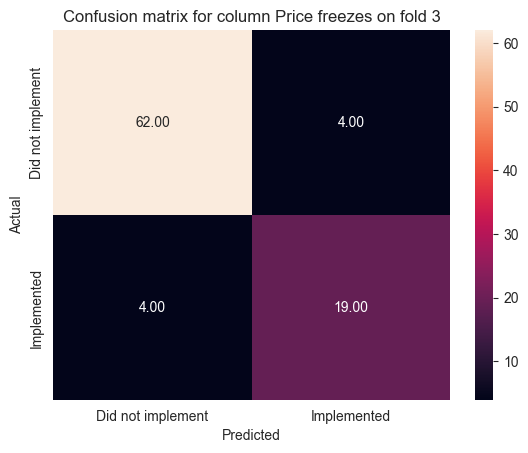

Precision: 0.8260869565217391
Recall: 0.8260869565217391
f1 score: 0.8260869565217391
Log loss: 0.596503246451824


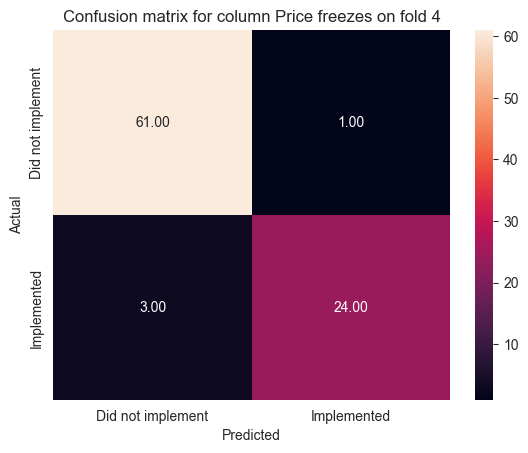

Precision: 0.96
Recall: 0.8888888888888888
f1 score: 0.923076923076923
Log loss: 0.8727150105355078


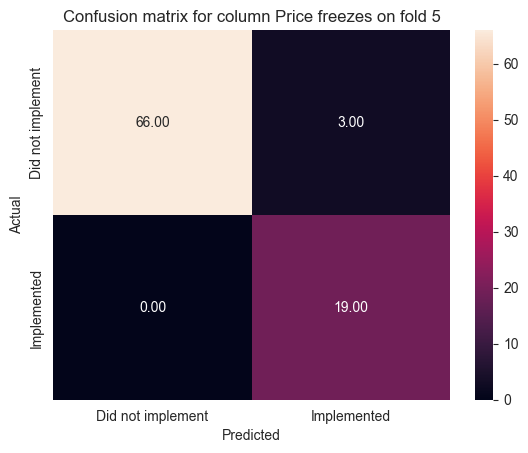

Precision: 0.8636363636363636
Recall: 1.0
f1 score: 0.9268292682926829
Log loss: 0.10258993729693987
Average of precision scores: 0.882805075930934
Average of recall scores: 0.8867181128050692
Average of f1 scores: 0.8829764073560469
Average of log loss scores: 0.4589304084140841


In [15]:
full_random_forests = train_and_test_model(RandomForestClassifier(class_weight='balanced'), combined_full_data, x_columns, y_columns)

While accuracy has improved compared to the models that didn't have the previous year's data as an available input, these are not all significantly better than the regression models. In fact, some are significantly worse on log loss. This likely happens because of overfitting. With the log loss metric, one or two wrong answers that are too confident (P too close to 0 or 1) can incur large losses. Regardless, we will still be saving off these models. In addition, the f1 score for tax reductions was still not good. This variable has consistently been the hardest to predict.

In [16]:
x_columns = ['log_gdp data', 'log_population data', 'democracy index data', 'log_population density', 'Net Trade Status', 'Price Control in previous year', 'Tax Reduction in previous year', 'No subsidy in previous year', 'Some subsidy in previous year', 'Price freezes in previous year']
final_full_random_forests = {}
for col in y_columns:
    final_full_random_forests[col] = RandomForestClassifier(class_weight='balanced').fit(combined_full_data[x_columns], combined_full_data[col])
    print("importances for predicting " + col)
    print(dict(zip(x_columns, final_full_random_forests[col].feature_importances_)))

importances for predicting Price Control
{'log_gdp data': 0.09968951917698651, 'log_population data': 0.06737132048372446, 'democracy index data': 0.0654463727514275, 'log_population density': 0.03659280396462269, 'Net Trade Status': 0.0031095605419258834, 'Price Control in previous year': 0.6102655740796449, 'Tax Reduction in previous year': 0.0044856800456662725, 'No subsidy in previous year': 0.036052623036677806, 'Some subsidy in previous year': 0.010163296186103208, 'Price freezes in previous year': 0.0668232497332207}
importances for predicting Tax Reduction
{'log_gdp data': 0.1907245317427955, 'log_population data': 0.17204915135788124, 'democracy index data': 0.1909608821361746, 'log_population density': 0.17442116232807034, 'Net Trade Status': 0.016826787113536912, 'Price Control in previous year': 0.02735885300870038, 'Tax Reduction in previous year': 0.11055939020295566, 'No subsidy in previous year': 0.03207977638723583, 'Some subsidy in previous year': 0.0236768787591435, 

Interestingly, this model appears to place less emphasis on where a policy was in the previous year. This is especially true for Tax Reduction, where the most important factors were actually the basic information! However, it is unlikely these factors are actually more important than the status of policies in previous years, since this is a worse performing model. We should be more confident in the insights from the regression models than in these.

In [17]:
inputs = combined_full_data_with_index[['Country Code'] + x_columns].copy()
outputs = combined_full_data[y_columns].copy()
models = final_full_random_forests
use_and_save_models(inputs, outputs, models, 'full_random_forest')

With all of these models complete, we have only a couple more models to train, test, and use. We will now train regression models and random forests on older data, and see how well they can predict newer data. For these models, we will only try to predict based on basic data, since if we also use data on past policies we will only have a couple years of data to train on. The goal of this isn't to produce better models than before, since we will be using the same techniques with less training data. The goal is simply to validate that these methods will work in the real world, since in the real world we will be using our model to predict outcomes in years after they were trained on.

We will write a function for the whole workflow, and then we will use it on both model types.

In [18]:
# setting all variables
test_data = basic_prediction_dataframes[2024]
training_data = pd.concat([basic_prediction_dataframes[2021], basic_prediction_dataframes[2022], basic_prediction_dataframes[2023]]).reset_index(drop=True)
x_columns = ['log_gdp data', 'log_population data', 'democracy index data', 'log_population density', 'Net Trade Status']
y_columns = ['Price Control', 'Tax Reduction', 'No subsidy', 'Some subsidy', 'Price freezes']

In [19]:
def train_test_and_save_models(training_data, test_data, x_columns, y_columns, model, model_name):
    models = {}
    predictions = {}
    probabilities = {}
    for col in y_columns:
        models[col] = model.fit(training_data[x_columns], training_data[col])
        predictions[col] = models[col].predict(test_data[x_columns])
        probabilities[col] = models[col].predict_proba(test_data[x_columns]).T[1]
        score = score_results(test_data[col], predictions[col], probabilities[col], 'Confusion matrix for ' + col)
        with open('../models/time_based_training/' + model_name + col + '.pkl','wb') as file:
            pickle.dump(models[col], file)
    # Only saving predictions on testing data. Predictions on training data have been covered in previous sections.
    test_dataframe_tosave = test_data.copy()
    for col in y_columns:
        test_dataframe_tosave.rename({col: 'Actual ' + col}, axis = 1, inplace = True)
        test_dataframe_tosave['Predicted ' + col] = predictions[col]
        test_dataframe_tosave['Probability ' + col] = probabilities[col]

    test_dataframe_tosave.to_csv('../final_predictions/' + model_name + '_predictions_on_testing.csv')



Logistic Regression Models


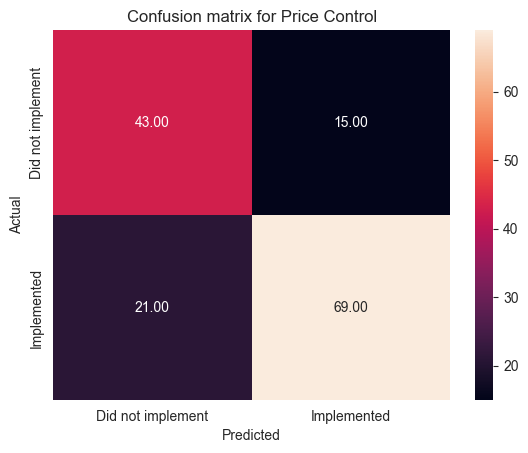

Precision: 0.8214285714285714
Recall: 0.7666666666666667
f1 score: 0.793103448275862
Log loss: 0.48054221409220066


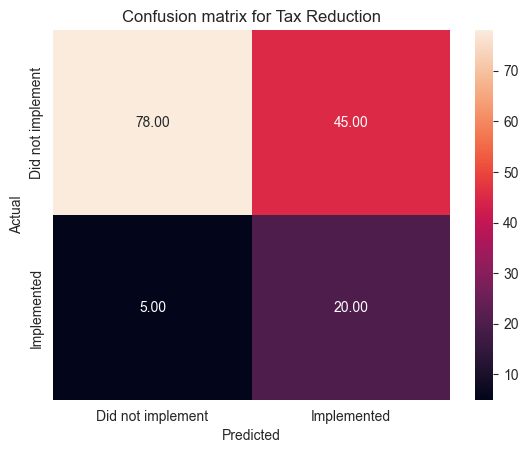

Precision: 0.3076923076923077
Recall: 0.8
f1 score: 0.4444444444444444
Log loss: 0.6254109738204021


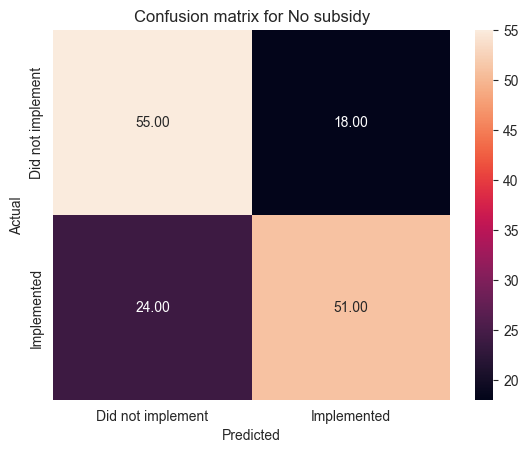

Precision: 0.7391304347826086
Recall: 0.68
f1 score: 0.7083333333333334
Log loss: 0.5673989078725006


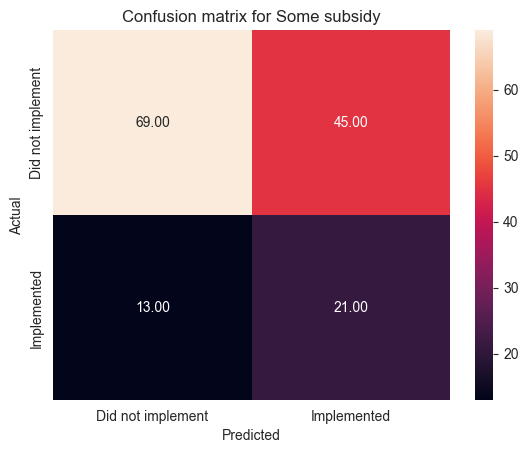

Precision: 0.3181818181818182
Recall: 0.6176470588235294
f1 score: 0.42000000000000004
Log loss: 0.6549880222658249


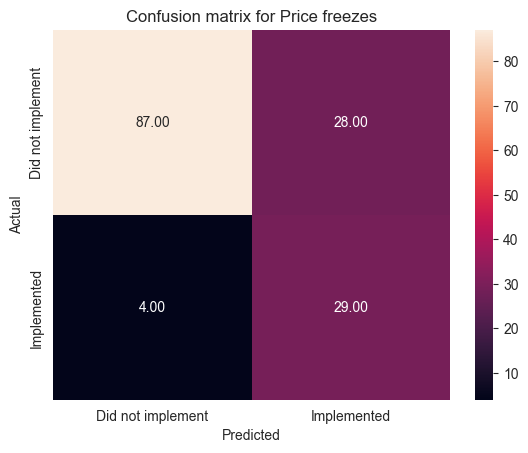

Precision: 0.5087719298245614
Recall: 0.8787878787878788
f1 score: 0.6444444444444445
Log loss: 0.458387767030053
Random Forests


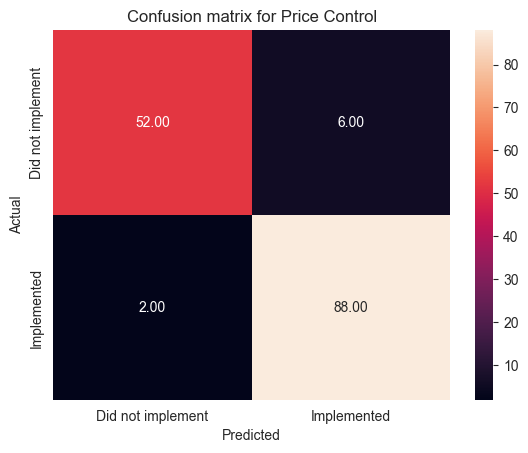

Precision: 0.9361702127659575
Recall: 0.9777777777777777
f1 score: 0.9565217391304347
Log loss: 0.1879685038095818


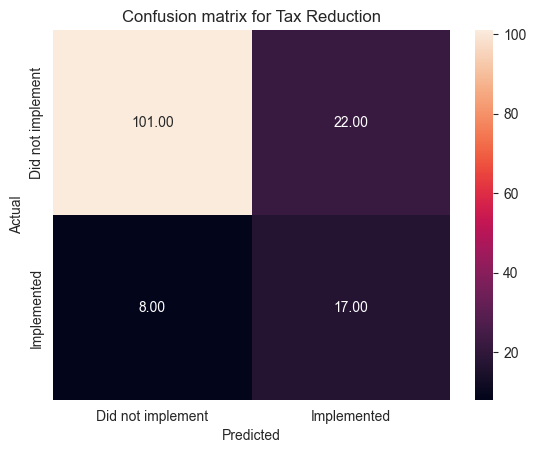

Precision: 0.4358974358974359
Recall: 0.68
f1 score: 0.53125
Log loss: 0.40606336604828913


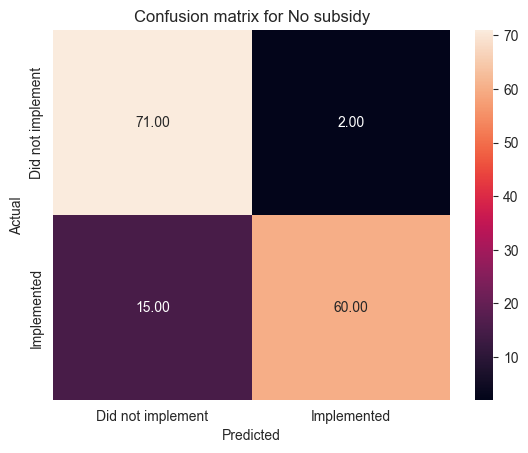

Precision: 0.967741935483871
Recall: 0.8
f1 score: 0.8759124087591241
Log loss: 0.7958466611203974


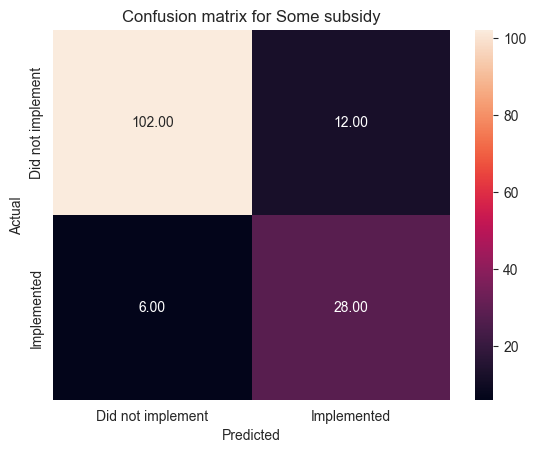

Precision: 0.7
Recall: 0.8235294117647058
f1 score: 0.7567567567567567
Log loss: 0.5798714593380918


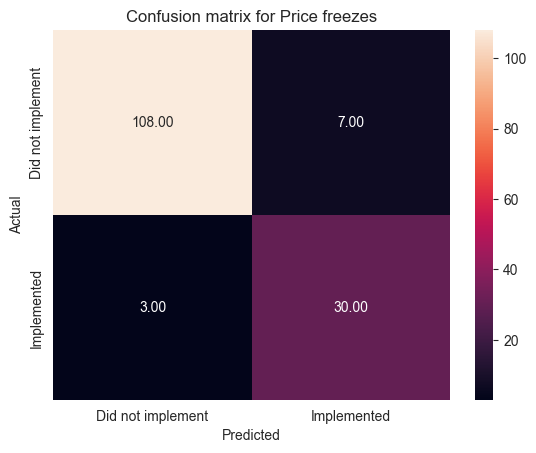

Precision: 0.8108108108108109
Recall: 0.9090909090909091
f1 score: 0.8571428571428571
Log loss: 0.1948416074752654


In [20]:
print('Logistic Regression Models')
train_test_and_save_models(training_data,test_data,x_columns,y_columns,LogisticRegression(class_weight='balanced'),'logistic_regression_')
print('Random Forests')
train_test_and_save_models(training_data,test_data,x_columns,y_columns,RandomForestClassifier(class_weight='balanced'),'random_forest_')

From this information, we can see that our results stay valid when using earlier data to predict later data. The f1 scores here were consistent with the average scores we saw earlier. Sometimes, they even end up higher, although this is likely just dude to random chance. Although there are some additional important nuances we can take away from this.

With all of the analysis done, models and results saved off, and accuracy scores measured, we will finish by recapping all the insights we can draw from this, and what the best way to use these models in practice is.

First, we have seen that all of our models predicted some factors far better than others. The best models were the ones that predicted whether or not a country would implement price controls and the ones predicting a recurring practice of price freezing. The worst models were the ones that predicted tax reductions and other types of subsidies. Models predicting tax reductions were especially bad, often having f1 scores of about .5. However, class imbalance accounts for some of the reason it is this low. Therefore, for anyone using predictions from these models to make business decisions, they should place more confidence in the models' ability to predict price controls and freezes than their ability to predict tax reductions or subsidies.

From our regression models, we were also able to determine the importance of various facts about a country for predicting their policy decisions, and the direction of those correlations.
- For predicting price controls, the most important factors are a country's GDP, population, and democracy index. For all of these factors, a lower value made a country more likely to implement the policy.
- For predicting tax reductions, the most important factors are GDP and democracy index, with population density also being important. Tax reductions were more likely in countries with a higher gdp and democracy indices, but lower population density. However, it's important to not place too much importance in these conclusions, since this model's predicted ability was fairly limited.
- For predicting if a country will implement an oil subsidy, the most important factors are population and democracy index, with gdp also being important. The likelihood of the policy being implemented goes up as the population and democracy index go up, and down as GDP goes up. However, similarly to the model for tax reductions, this model has limited predictive ability.
- For predicting if a country will implement recurring price freezes, the most important factor is the democracy index, with gdp also being important. The policy gets more likely as both factors go down.


From several different model types, we were able to determine the best models for predicting oil regulation policies as measured by their confusion matrices and log loss functions on the test data.
- When the only inputs about a country are gdp, population, democracy index, population density, and whether or not they are net oil exporters, the random forest model was by far the best model. For anyone looking to predict these policies who only has access to this data, they should be using the random forest model.
- When the inputs also included data on a country's policy decisions in a previous year, both models (unsurprisingly) performed significantly better. When looking at what the most important predictive factors were for these models, the most important factor was what the policy was in the previous year. Other factors retained similar relative importance, although these were often smaller, since the importance of each input variable goes down as more input variables are added. In this case, the random forest wasn't unequivocally better, since it was far more prone to overfitting, and the log loss could be high on the test data due to large losses from a small number or guesses where a very small probability was assigned to the correct value. For an end user of the model, the regression model is more useful for producing more nuanced probability estimates, while both models are similarly useful if the only goal is to produce a binary prediction.

Finally, we will discuss insights from using data from earlier years to predict data from later years:
- Both the linear regression and random forest models got slightly less accurate than when the data from each year was all mixed up. This suggests that the models were picking up on a little bit on patterns that differed year to year, but most of its insights were transferable when looking forwards in time
- The random forest models sometimes had high log loss scores compared to when its confusion matrix would suggest. For anyone using the probabilities produced by these models, this suggests they should treat extreme probabilities produced by the model as actually being a bit closer to 50%.
- Both models perform poorly when predicting tax reductions. For this output, the model on just the basic data does not translate well across years, and should not be used. The only models that should be used to predict these policies into the future are models that include data on the policies implemented in past years as inputs (aka the 'full' models from this notebook).

With all of these insights and caveats in mind, these models can be very useful for anyone who needs to make decisions affected by oil market regulations across the world, such as leaders of businesses that are heavy consumers of oil. Using these models, one can get a good idea of what a country will do in the next year by knowing only data that's easily publicly accessible!